In [ ]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

def load_user_data(users_file):
    """Load and process users.json"""
    with open(users_file, 'r') as f:
        users = json.load(f)
    return pd.DataFrame(users)

def load_and_process_chats(conversations_file, users_df):
    """Load and process conversations.json with user information"""
    # Load the JSON data
    with open(conversations_file, 'r') as f:
        conversations = json.load(f)

    # Flatten the chat messages
    all_messages = []

    for conv in conversations:
        # Get user info for this conversation
        user_id = conv['account']['uuid']
        user_info = users_df[users_df['uuid'] == user_id].iloc[0] if len(users_df[users_df['uuid'] == user_id]) > 0 else None

        for msg in conv['chat_messages']:
            message = {
                'conversation_id': conv['uuid'],
                'conversation_name': conv['name'],
                'message_id': msg['uuid'],
                'sender': msg['sender'],
                'text': msg['text'],
                'timestamp': msg['created_at'],
                'has_files': len(msg.get('files', [])) > 0,
                'user_id': user_id,
                'user_name': user_info['full_name'] if user_info is not None else None,
                'user_email': user_info['email_address'] if user_info is not None else None
            }
            all_messages.append(message)

    return pd.DataFrame(all_messages)

def classify_task(text):
    """Simplified version of paper's task classification"""
    patterns = {
        'Programming/Technical': r'code|program|function|bug|error|python|javascript|api|debug',
        'Writing/Content': r'write|draft|summarize|article|content|explain|rephrase',
        'Analysis/Data': r'analyze|calculate|data|statistics|plot|graph|research|study',
        'Learning/Education': r'learn|teach|understand|concept|explain|how|what|why',
        'Business/Strategy': r'business|strategy|market|plan|company|startup'
    }

    text = text.lower()
    for category, pattern in patterns.items():
        if re.search(pattern, text):
            return category
    return 'Other'

def analyze_interaction_type(text):
    """Classify as automation or augmentation (similar to paper)"""
    automation = r'\b(write|generate|create|make|give me|do|solve)\b'
    augmentation = r'\b(help|suggest|improve|review|explain|teach|guide|understand)\b'

    text = text.lower()
    is_automation = bool(re.search(automation, text))
    is_augmentation = bool(re.search(augmentation, text))

    if is_automation and not is_augmentation:
        return 'Automation'
    elif is_augmentation and not is_automation:
        return 'Augmentation'
    elif is_automation and is_augmentation:
        return 'Mixed'
    return 'Other'

def analyze_chats(df):
    """Comprehensive analysis of chat data"""
    # Basic statistics per user
    user_stats = df.groupby('user_name').agg({
        'conversation_id': 'nunique',
        'message_id': 'count',
        'has_files': 'sum'
    }).rename(columns={
        'conversation_id': 'total_conversations',
        'message_id': 'total_messages',
        'has_files': 'files_shared'
    })

    # Task classification
    df['task_category'] = df[df['sender'] == 'human']['text'].apply(classify_task)
    task_distribution = df['task_category'].value_counts()

    # Interaction type analysis
    df['interaction_type'] = df[df['sender'] == 'human']['text'].apply(analyze_interaction_type)
    interaction_distribution = df['interaction_type'].value_counts()

    # Time analysis
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.date
    hourly_activity = df['hour'].value_counts().sort_index()
    daily_activity = df.groupby('day').size()

    # Visualizations
    plt.figure(figsize=(20, 15))

    # 1. Task Distribution
    plt.subplot(3, 2, 1)
    task_distribution.plot(kind='bar')
    plt.title('Distribution of Tasks')
    plt.xticks(rotation=45)

    # 2. Automation vs Augmentation
    plt.subplot(3, 2, 2)
    interaction_distribution.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Interaction Types')

    # 3. Hourly Activity
    plt.subplot(3, 2, 3)
    hourly_activity.plot(kind='line')
    plt.title('Activity by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Messages')

    # 4. Daily Activity
    plt.subplot(3, 2, 4)
    daily_activity.plot(kind='line')
    plt.title('Activity Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Messages')

    # 5. Message Length Distribution by Type
    plt.subplot(3, 2, 5)
    df['message_length'] = df['text'].str.len()
    sns.boxplot(data=df, x='task_category', y='message_length')
    plt.title('Message Length by Task Category')
    plt.xticks(rotation=45)

    # 6. File Usage Over Time
    plt.subplot(3, 2, 6)
    df[df['has_files']].groupby('day').size().plot(kind='line')
    plt.title('File Sharing Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Files Shared')

    plt.tight_layout()
    plt.show()

    return {
        'user_statistics': user_stats,
        'task_distribution': task_distribution,
        'interaction_distribution': interaction_distribution,
        'hourly_patterns': hourly_activity,
        'daily_patterns': daily_activity
    }

# To use in Colab:
# 1. Upload users.json and conversations.json
# 2. Run:
users_df = load_user_data('/content/users.json')
df = load_and_process_chats('/content/conversations.json', users_df)
results = analyze_chats(df)

# Print summary statistics
print("\nUser Statistics:")
print(results['user_statistics'])
print("\nTask Distribution:")
print(results['task_distribution'])
print("\nInteraction Types:")
print(results['interaction_distribution'])

In [ ]:
!pip install pandas numpy seaborn


=== Chat Analysis Statistics ===

Total Conversations: 438
Total Messages: 4684
Average Messages per Conversation: 10.7

Task Distribution:
-----------------
Other                    :  1108 (47.4%)
Programming/Technical    :   609 (26.1%)
Learning/Education       :   285 (12.2%)
Writing/Content          :   242 (10.4%)
Analysis/Data            :    74 (3.2%)
Business/Strategy        :    18 (0.8%)

Interaction Types:
-----------------
Other          :  1461 (62.5%)
Automation     :   688 (29.5%)
Augmentation   :    95 (4.1%)
Mixed          :    92 (3.9%)


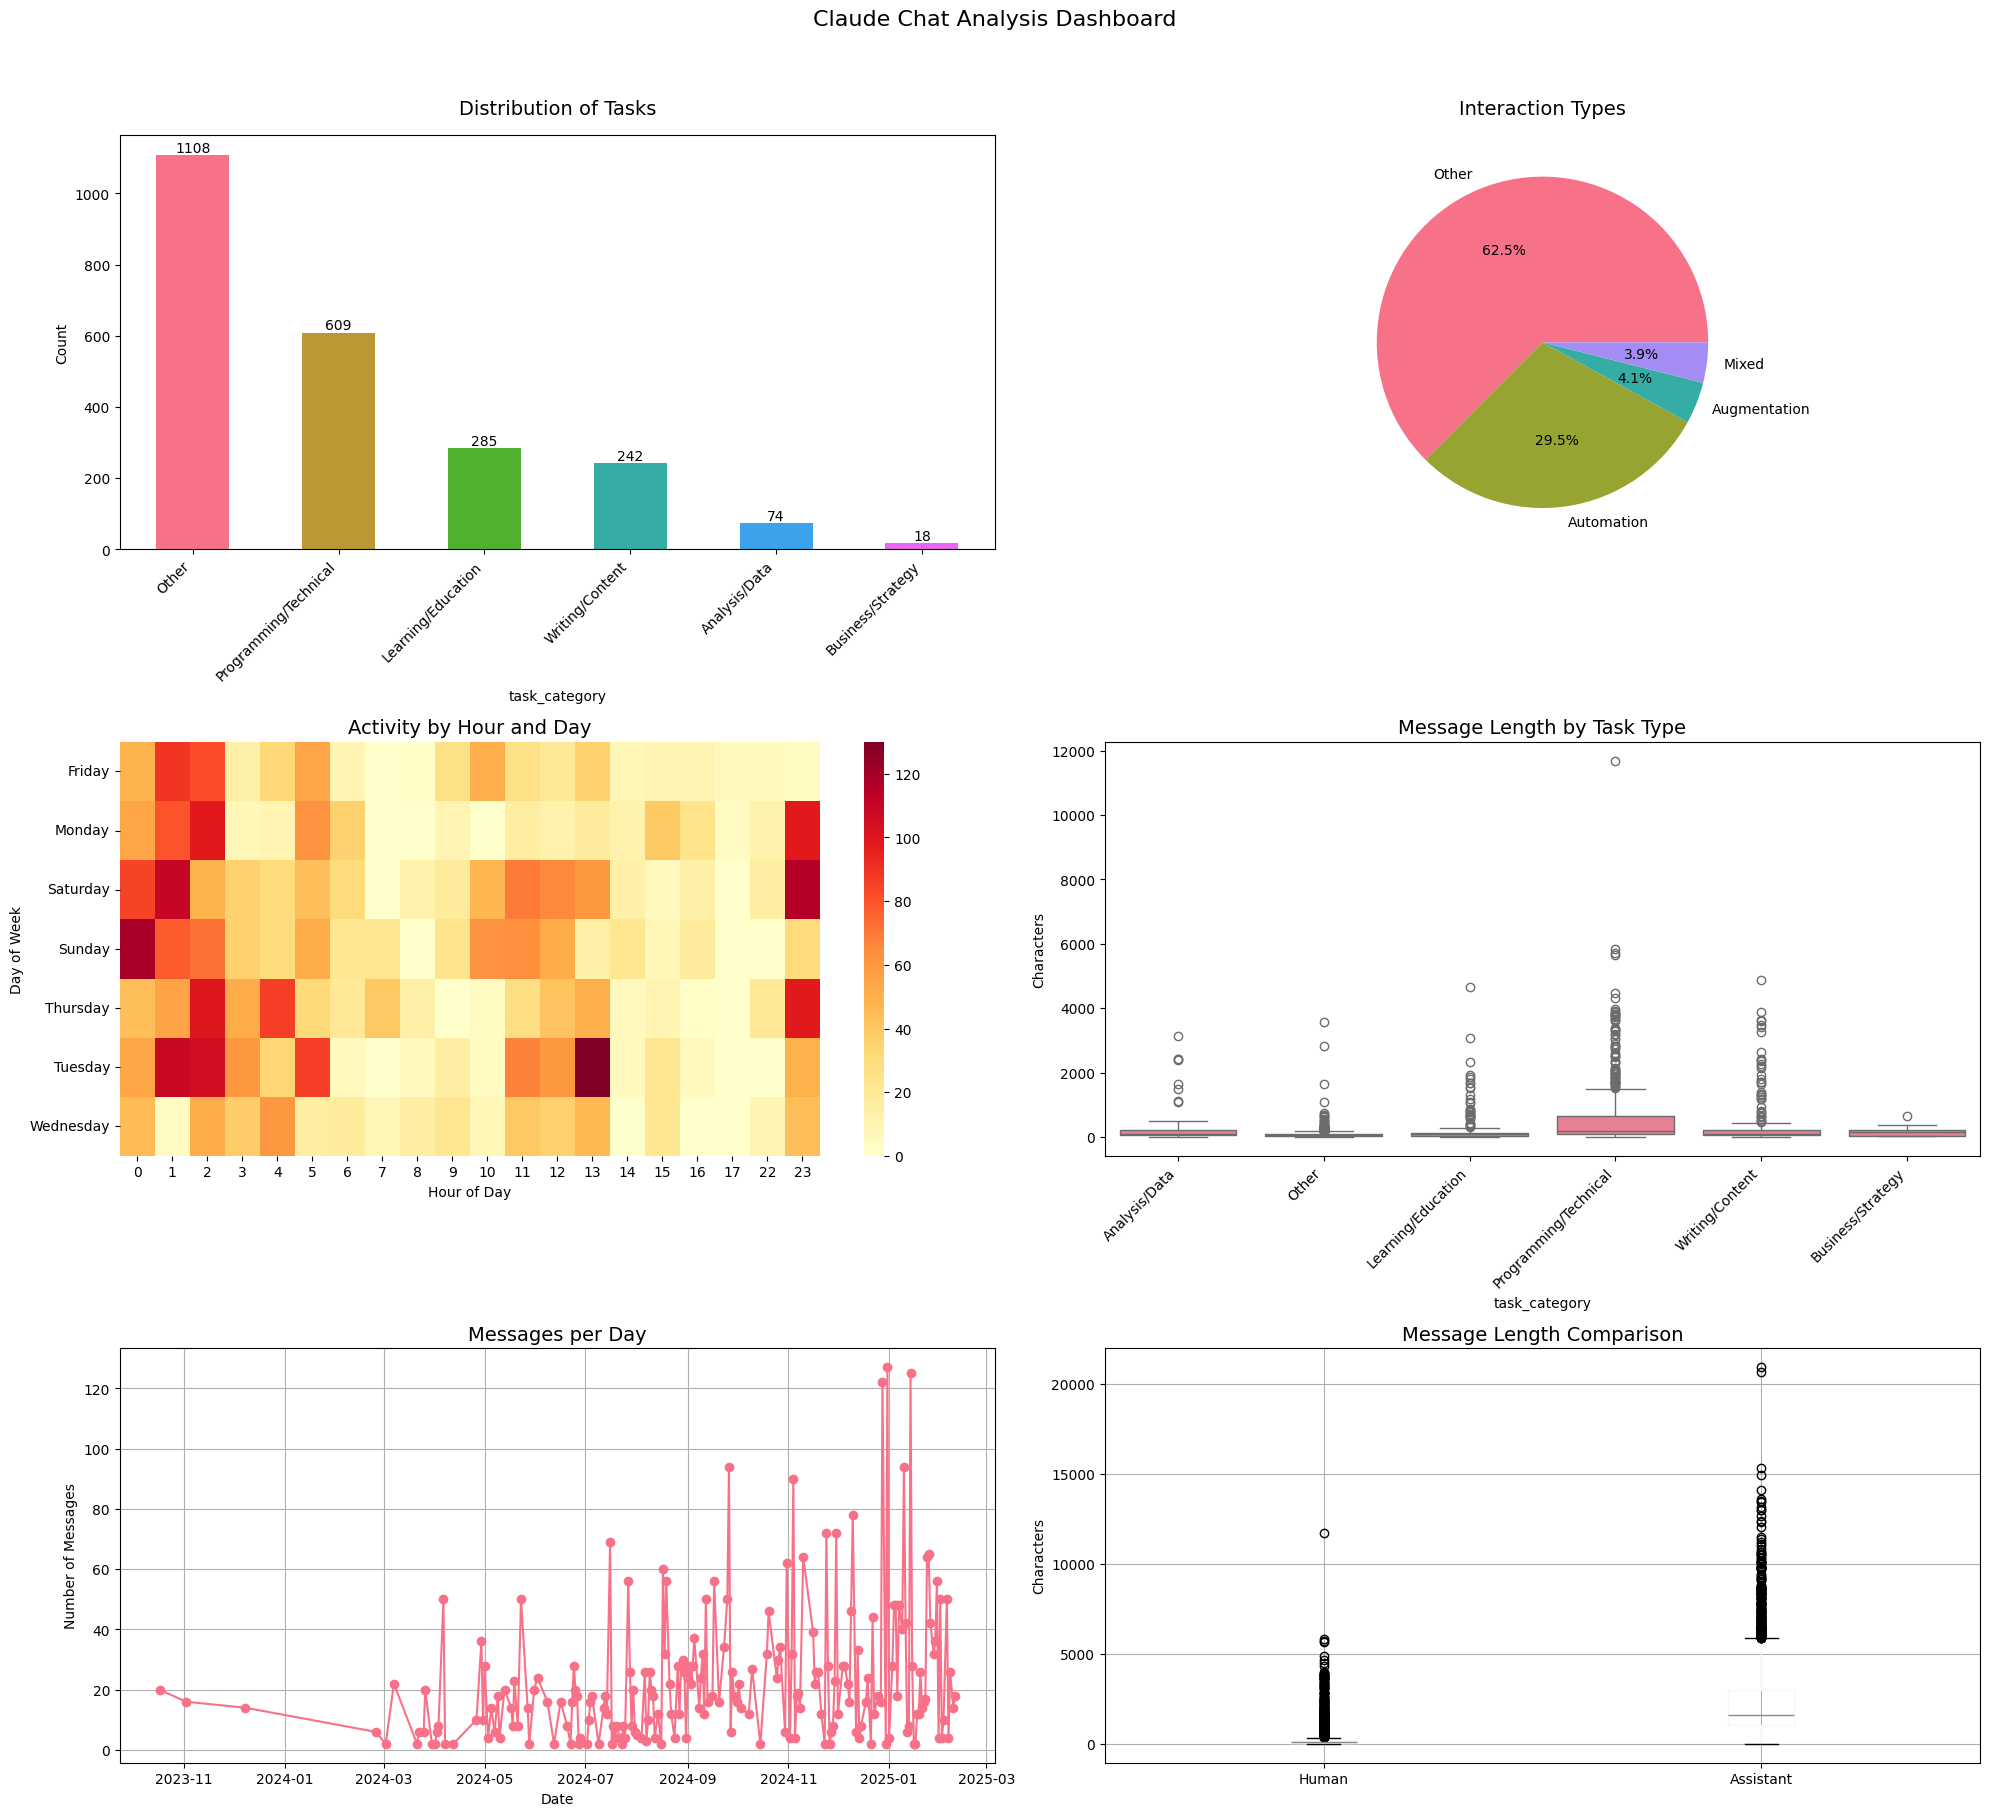

In [ ]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

plt.style.use('default')  # Use default style instead of seaborn
sns.set_palette("husl")   # Set seaborn color palette

def load_user_data(users_file):
    """Load and process users.json"""
    with open(users_file, 'r') as f:
        users = json.load(f)
    return pd.DataFrame(users)

def load_and_process_chats(conversations_file, users_df):
    """Load and process conversations.json with user information"""
    with open(conversations_file, 'r') as f:
        conversations = json.load(f)

    all_messages = []
    for conv in conversations:
        user_id = conv['account']['uuid']
        user_info = users_df[users_df['uuid'] == user_id].iloc[0] if len(users_df[users_df['uuid'] == user_id]) > 0 else None

        for msg in conv['chat_messages']:
            message = {
                'conversation_id': conv['uuid'],
                'conversation_name': conv['name'],
                'message_id': msg['uuid'],
                'sender': msg['sender'],
                'text': msg['text'],
                'timestamp': msg['created_at'],
                'has_files': len(msg.get('files', [])) > 0,
                'user_id': user_id,
                'user_name': user_info['full_name'] if user_info is not None else None,
                'user_email': user_info['email_address'] if user_info is not None else None
            }
            all_messages.append(message)

    return pd.DataFrame(all_messages)

def classify_task(text):
    patterns = {
        'Programming/Technical': r'code|program|function|bug|error|python|javascript|api|debug',
        'Writing/Content': r'write|draft|summarize|article|content|explain|rephrase',
        'Analysis/Data': r'analyze|calculate|data|statistics|plot|graph|research|study',
        'Learning/Education': r'learn|teach|understand|concept|explain|how|what|why',
        'Business/Strategy': r'business|strategy|market|plan|company|startup'
    }

    text = str(text).lower()
    for category, pattern in patterns.items():
        if re.search(pattern, text):
            return category
    return 'Other'

def analyze_interaction_type(text):
    automation = r'\b(write|generate|create|make|give me|do|solve)\b'
    augmentation = r'\b(help|suggest|improve|review|explain|teach|guide|understand)\b'

    text = str(text).lower()
    is_automation = bool(re.search(automation, text))
    is_augmentation = bool(re.search(augmentation, text))

    if is_automation and not is_augmentation:
        return 'Automation'
    elif is_augmentation and not is_automation:
        return 'Augmentation'
    elif is_automation and is_augmentation:
        return 'Mixed'
    return 'Other'

def analyze_chats(df):
    """Enhanced analysis with better visualizations"""
    # Create figure with better spacing
    plt.figure(figsize=(20, 25))

    # 1. Task Distribution
    plt.subplot(4, 2, 1)
    df['task_category'] = df[df['sender'] == 'human']['text'].apply(classify_task)
    task_dist = df['task_category'].value_counts()
    ax = task_dist.plot(kind='bar', color=sns.color_palette("husl", len(task_dist)))
    plt.title('Distribution of Tasks', fontsize=14, pad=15)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')

    # Add value labels
    for i, v in enumerate(task_dist):
        plt.text(i, v, str(v), ha='center', va='bottom')

    # 2. Interaction Types
    plt.subplot(4, 2, 2)
    df['interaction_type'] = df[df['sender'] == 'human']['text'].apply(analyze_interaction_type)
    interaction_dist = df['interaction_type'].value_counts()
    plt.pie(interaction_dist, labels=interaction_dist.index, autopct='%1.1f%%',
            colors=sns.color_palette("husl", len(interaction_dist)))
    plt.title('Interaction Types', fontsize=14, pad=15)

    # 3. Activity Heatmap
    plt.subplot(4, 2, 3)
    df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
    df['weekday'] = pd.to_datetime(df['timestamp']).dt.day_name()
    activity_pivot = pd.crosstab(df['weekday'], df['hour'])
    sns.heatmap(activity_pivot, cmap='YlOrRd')
    plt.title('Activity by Hour and Day', fontsize=14)
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')

    # 4. Message Length Distribution
    plt.subplot(4, 2, 4)
    df['message_length'] = df['text'].str.len()
    sns.boxplot(data=df, x='task_category', y='message_length')
    plt.title('Message Length by Task Type', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Characters')

    # 5. Daily Activity
    plt.subplot(4, 2, 5)
    daily_activity = df.groupby(pd.to_datetime(df['timestamp']).dt.date).size()
    daily_activity.plot(kind='line', marker='o')
    plt.title('Messages per Day', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Number of Messages')
    plt.grid(True)

    # 6. Response Time Analysis
    plt.subplot(4, 2, 6)
    human_msgs = df[df['sender'] == 'human']
    assistant_msgs = df[df['sender'] == 'assistant']
    msg_lengths = pd.concat([
        human_msgs['text'].str.len().rename('Human'),
        assistant_msgs['text'].str.len().rename('Assistant')
    ], axis=1)
    msg_lengths.boxplot()
    plt.title('Message Length Comparison', fontsize=14)
    plt.ylabel('Characters')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle('Claude Chat Analysis Dashboard', fontsize=16, y=0.98)

    # Calculate statistics
    stats = {
        'total_conversations': df['conversation_id'].nunique(),
        'total_messages': len(df),
        'avg_messages_per_conv': len(df) / df['conversation_id'].nunique(),
        'task_distribution': task_dist,
        'interaction_distribution': interaction_dist,
        'daily_activity': daily_activity
    }

    return stats

def print_statistics(results):
    """Print statistics in a formatted way"""
    print("\n=== Chat Analysis Statistics ===\n")

    print(f"Total Conversations: {results['total_conversations']}")
    print(f"Total Messages: {results['total_messages']}")
    print(f"Average Messages per Conversation: {results['avg_messages_per_conv']:.1f}")

    print("\nTask Distribution:")
    print("-----------------")
    for task, count in results['task_distribution'].items():
        print(f"{task:<25}: {count:>5} ({count/sum(results['task_distribution'])*100:.1f}%)")

    print("\nInteraction Types:")
    print("-----------------")
    for type_, count in results['interaction_distribution'].items():
        print(f"{type_:<15}: {count:>5} ({count/sum(results['interaction_distribution'])*100:.1f}%)")

# Usage in Colab:
users_df = load_user_data('/content/users.json')
df = load_and_process_chats('/content/conversations.json', users_df)
results = analyze_chats(df)
print_statistics(results)
plt.show()


=== Chat Analysis Statistics ===

Total Conversations: 438
Total Messages: 4684
Average Messages per Conversation: 10.7

Task Distribution:
-----------------
Programming/Technical    :   663 (28.4%)
Other                    :   578 (24.7%)
Writing/Content          :   368 (15.8%)
Learning/Education       :   235 (10.1%)
Creative/Design          :   222 (9.5%)
Analysis/Data            :   145 (6.2%)
Business/Strategy        :    75 (3.2%)
Personal/Lifestyle       :    48 (2.1%)
Math/Science             :     2 (0.1%)

Interaction Types:
-----------------
Other          :  1461 (62.5%)
Automation     :   688 (29.5%)
Augmentation   :    95 (4.1%)
Mixed          :    92 (3.9%)


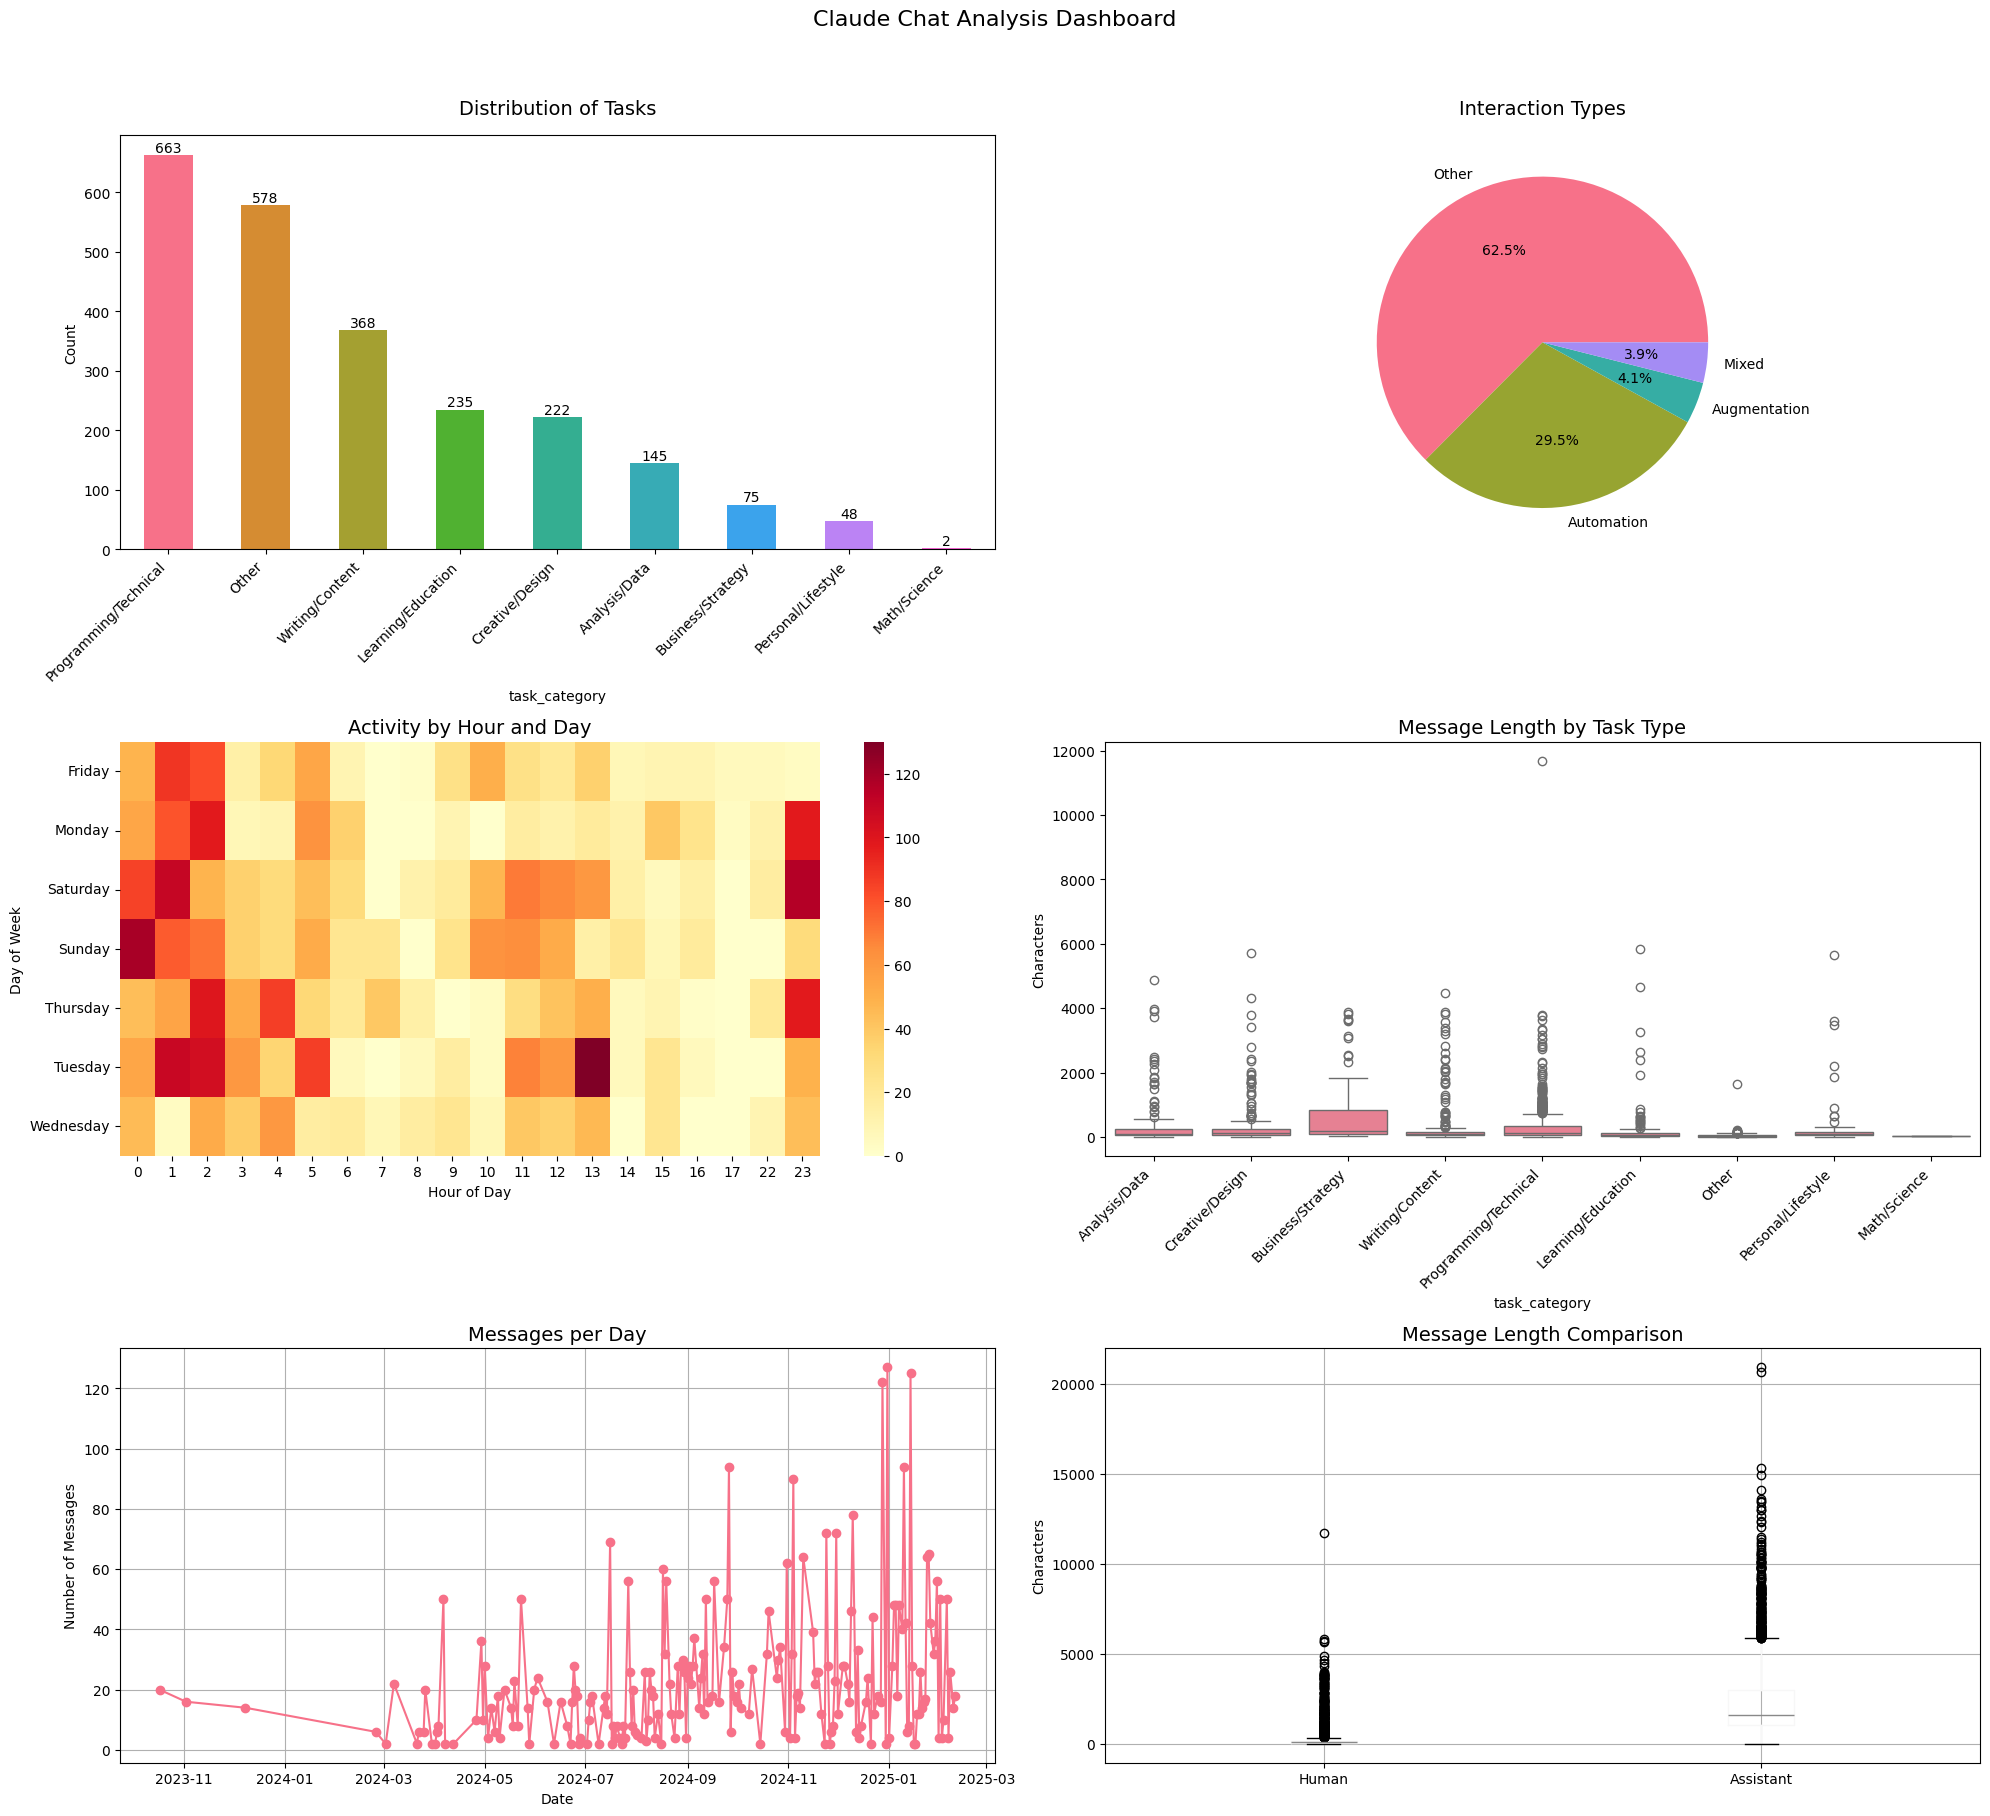

In [ ]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

plt.style.use('default')  # Use default style instead of seaborn
sns.set_palette("husl")   # Set seaborn color palette

def load_user_data(users_file):
    """Load and process users.json"""
    with open(users_file, 'r') as f:
        users = json.load(f)
    return pd.DataFrame(users)

def load_and_process_chats(conversations_file, users_df):
    """Load and process conversations.json with user information"""
    with open(conversations_file, 'r') as f:
        conversations = json.load(f)

    all_messages = []
    for conv in conversations:
        user_id = conv['account']['uuid']
        user_info = users_df[users_df['uuid'] == user_id].iloc[0] if len(users_df[users_df['uuid'] == user_id]) > 0 else None

        for msg in conv['chat_messages']:
            message = {
                'conversation_id': conv['uuid'],
                'conversation_name': conv['name'],
                'message_id': msg['uuid'],
                'sender': msg['sender'],
                'text': msg['text'],
                'timestamp': msg['created_at'],
                'has_files': len(msg.get('files', [])) > 0,
                'user_id': user_id,
                'user_name': user_info['full_name'] if user_info is not None else None,
                'user_email': user_info['email_address'] if user_info is not None else None
            }
            all_messages.append(message)

    return pd.DataFrame(all_messages)

def classify_task(text):
    """
    Classifies text into task categories with expanded patterns and categories
    Returns the most likely category based on keyword matching
    """
    patterns = {
        'Programming/Technical': r'code|program|function|bug|error|python|javascript|java|css|html|sql|api|debug|compile|runtime|server|database|git|docker|framework|library|package|npm|pip|dependency|algorithm|data\s?structure|variable|class|object|method|interface|exception|try|catch|async|promise|callback|rest|json|xml|http|request|response',

        'Writing/Content': r'write|draft|summarize|article|content|explain|rephrase|essay|blog|post|story|script|narrative|review|edit|proofread|grammar|spelling|tone|style|voice|paragraph|sentence|outline|structure|format|composition|document|letter|email|report|presentation|thesis|dissertation',

        'Analysis/Data': r'analyze|calculate|data|statistics|plot|graph|research|study|trend|pattern|correlation|regression|average|mean|median|mode|standard\s?deviation|variance|distribution|sample|population|hypothesis|test|significance|p-value|confidence|interval|prediction|forecast|model|metric|kpi|dashboard|visualization|chart|insight|inference|conclusion',

        'Learning/Education': r'learn|teach|understand|concept|explain|how|what|why|education|course|lesson|tutorial|guide|instruction|example|practice|exercise|homework|assignment|quiz|test|exam|grade|score|curriculum|syllabus|topic|subject|discipline|field|theory|principle|fundamental|basic|advanced',

        'Business/Strategy': r'business|strategy|market|plan|company|startup|product|service|customer|client|user|competitor|industry|sector|segment|target|goal|objective|mission|vision|value|proposition|revenue|cost|profit|loss|budget|forecast|projection|growth|scale|expansion|operation|process|workflow|team|organization|management|leadership',

        'Creative/Design': r'design|create|logo|image|graphic|art|creative|style|color|layout|template|theme|brand|identity|visual|aesthetic|interface|ui|ux|user\s?experience|wireframe|prototype|mockup|sketch|illustration|animation|video|audio|music|sound|effect',

        'Personal/Lifestyle': r'advice|help|suggestion|recommendation|opinion|personal|life|work|career|job|interview|resume|cv|skill|experience|habit|routine|schedule|plan|goal|motivation|productivity|health|wellness|fitness|diet|nutrition|exercise|meditation|mindfulness|relationship|family|friend',

        'Math/Science': r'math|mathematics|equation|formula|calculation|proof|theorem|physics|chemistry|biology|science|scientific|experiment|observation|measurement|unit|conversion|geometry|algebra|calculus|trigonometry|probability|element|compound|reaction|force|energy|mass|volume|temperature'
    }

    text = str(text).lower()
    category_scores = {category: 0 for category in patterns.keys()}

    # Count matches for each category
    for category, pattern in patterns.items():
        matches = re.findall(pattern, text)
        category_scores[category] = len(matches)

    # If we found any matches, return the category with the most matches
    if any(category_scores.values()):
        return max(category_scores.items(), key=lambda x: x[1])[0]

    # If no matches found, try to catch some additional general patterns
    general_patterns = {
        'Writing/Content': r'can you help|please write|need help with',
        'Learning/Education': r'could you explain|i want to understand|tell me about',
        'Personal/Lifestyle': r'what should i|how can i|i need advice',
        'Analysis/Data': r'look at this|check this|review this'
    }

    for category, pattern in general_patterns.items():
        if re.search(pattern, text):
            return category

    return 'Other'

def analyze_interaction_type(text):
    automation = r'\b(write|generate|create|make|give me|do|solve)\b'
    augmentation = r'\b(help|suggest|improve|review|explain|teach|guide|understand)\b'

    text = str(text).lower()
    is_automation = bool(re.search(automation, text))
    is_augmentation = bool(re.search(augmentation, text))

    if is_automation and not is_augmentation:
        return 'Automation'
    elif is_augmentation and not is_automation:
        return 'Augmentation'
    elif is_automation and is_augmentation:
        return 'Mixed'
    return 'Other'

def analyze_chats(df):
    """Enhanced analysis with better visualizations"""
    # Create figure with better spacing
    plt.figure(figsize=(20, 25))

    # 1. Task Distribution
    plt.subplot(4, 2, 1)
    df['task_category'] = df[df['sender'] == 'human']['text'].apply(classify_task)
    task_dist = df['task_category'].value_counts()
    ax = task_dist.plot(kind='bar', color=sns.color_palette("husl", len(task_dist)))
    plt.title('Distribution of Tasks', fontsize=14, pad=15)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')

    # Add value labels
    for i, v in enumerate(task_dist):
        plt.text(i, v, str(v), ha='center', va='bottom')

    # 2. Interaction Types
    plt.subplot(4, 2, 2)
    df['interaction_type'] = df[df['sender'] == 'human']['text'].apply(analyze_interaction_type)
    interaction_dist = df['interaction_type'].value_counts()
    plt.pie(interaction_dist, labels=interaction_dist.index, autopct='%1.1f%%',
            colors=sns.color_palette("husl", len(interaction_dist)))
    plt.title('Interaction Types', fontsize=14, pad=15)

    # 3. Activity Heatmap
    plt.subplot(4, 2, 3)
    df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
    df['weekday'] = pd.to_datetime(df['timestamp']).dt.day_name()
    activity_pivot = pd.crosstab(df['weekday'], df['hour'])
    sns.heatmap(activity_pivot, cmap='YlOrRd')
    plt.title('Activity by Hour and Day', fontsize=14)
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')

    # 4. Message Length Distribution
    plt.subplot(4, 2, 4)
    df['message_length'] = df['text'].str.len()
    sns.boxplot(data=df, x='task_category', y='message_length')
    plt.title('Message Length by Task Type', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Characters')

    # 5. Daily Activity
    plt.subplot(4, 2, 5)
    daily_activity = df.groupby(pd.to_datetime(df['timestamp']).dt.date).size()
    daily_activity.plot(kind='line', marker='o')
    plt.title('Messages per Day', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Number of Messages')
    plt.grid(True)

    # 6. Response Time Analysis
    plt.subplot(4, 2, 6)
    human_msgs = df[df['sender'] == 'human']
    assistant_msgs = df[df['sender'] == 'assistant']
    msg_lengths = pd.concat([
        human_msgs['text'].str.len().rename('Human'),
        assistant_msgs['text'].str.len().rename('Assistant')
    ], axis=1)
    msg_lengths.boxplot()
    plt.title('Message Length Comparison', fontsize=14)
    plt.ylabel('Characters')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle('Claude Chat Analysis Dashboard', fontsize=16, y=0.98)

    # Calculate statistics
    stats = {
        'total_conversations': df['conversation_id'].nunique(),
        'total_messages': len(df),
        'avg_messages_per_conv': len(df) / df['conversation_id'].nunique(),
        'task_distribution': task_dist,
        'interaction_distribution': interaction_dist,
        'daily_activity': daily_activity
    }

    return stats

def print_statistics(results):
    """Print statistics in a formatted way"""
    print("\n=== Chat Analysis Statistics ===\n")

    print(f"Total Conversations: {results['total_conversations']}")
    print(f"Total Messages: {results['total_messages']}")
    print(f"Average Messages per Conversation: {results['avg_messages_per_conv']:.1f}")

    print("\nTask Distribution:")
    print("-----------------")
    for task, count in results['task_distribution'].items():
        print(f"{task:<25}: {count:>5} ({count/sum(results['task_distribution'])*100:.1f}%)")

    print("\nInteraction Types:")
    print("-----------------")
    for type_, count in results['interaction_distribution'].items():
        print(f"{type_:<15}: {count:>5} ({count/sum(results['interaction_distribution'])*100:.1f}%)")

# Usage example:
if __name__ == "__main__":
    users_df = load_user_data('users.json')
    df = load_and_process_chats('conversations.json', users_df)
    results = analyze_chats(df)
    print_statistics(results)
    plt.show()


=== Chat Analysis Statistics ===

Total Conversations: 438
Total Messages: 4684
Average Messages per Conversation: 10.7

Task Distribution:
-----------------
Programming/Technical    :   902 (38.6%)
Writing/Content          :   296 (12.7%)
Uncategorized            :   284 (12.2%)
Creative/Design          :   254 (10.9%)
Learning/Education       :   237 (10.1%)
Analysis/Data            :   144 (6.2%)
Personal/Lifestyle       :   112 (4.8%)
Business/Strategy        :    52 (2.2%)
Math/Science             :    34 (1.5%)
General Questions        :    21 (0.9%)

Interaction Types:
-----------------
Other          :   808 (34.6%)
Question       :   664 (28.4%)
Automation     :   358 (15.3%)
Inquiry        :   184 (7.9%)
Conversational :   179 (7.7%)
Augmentation   :    91 (3.9%)
Mixed          :    50 (2.1%)
Clarification  :     2 (0.1%)


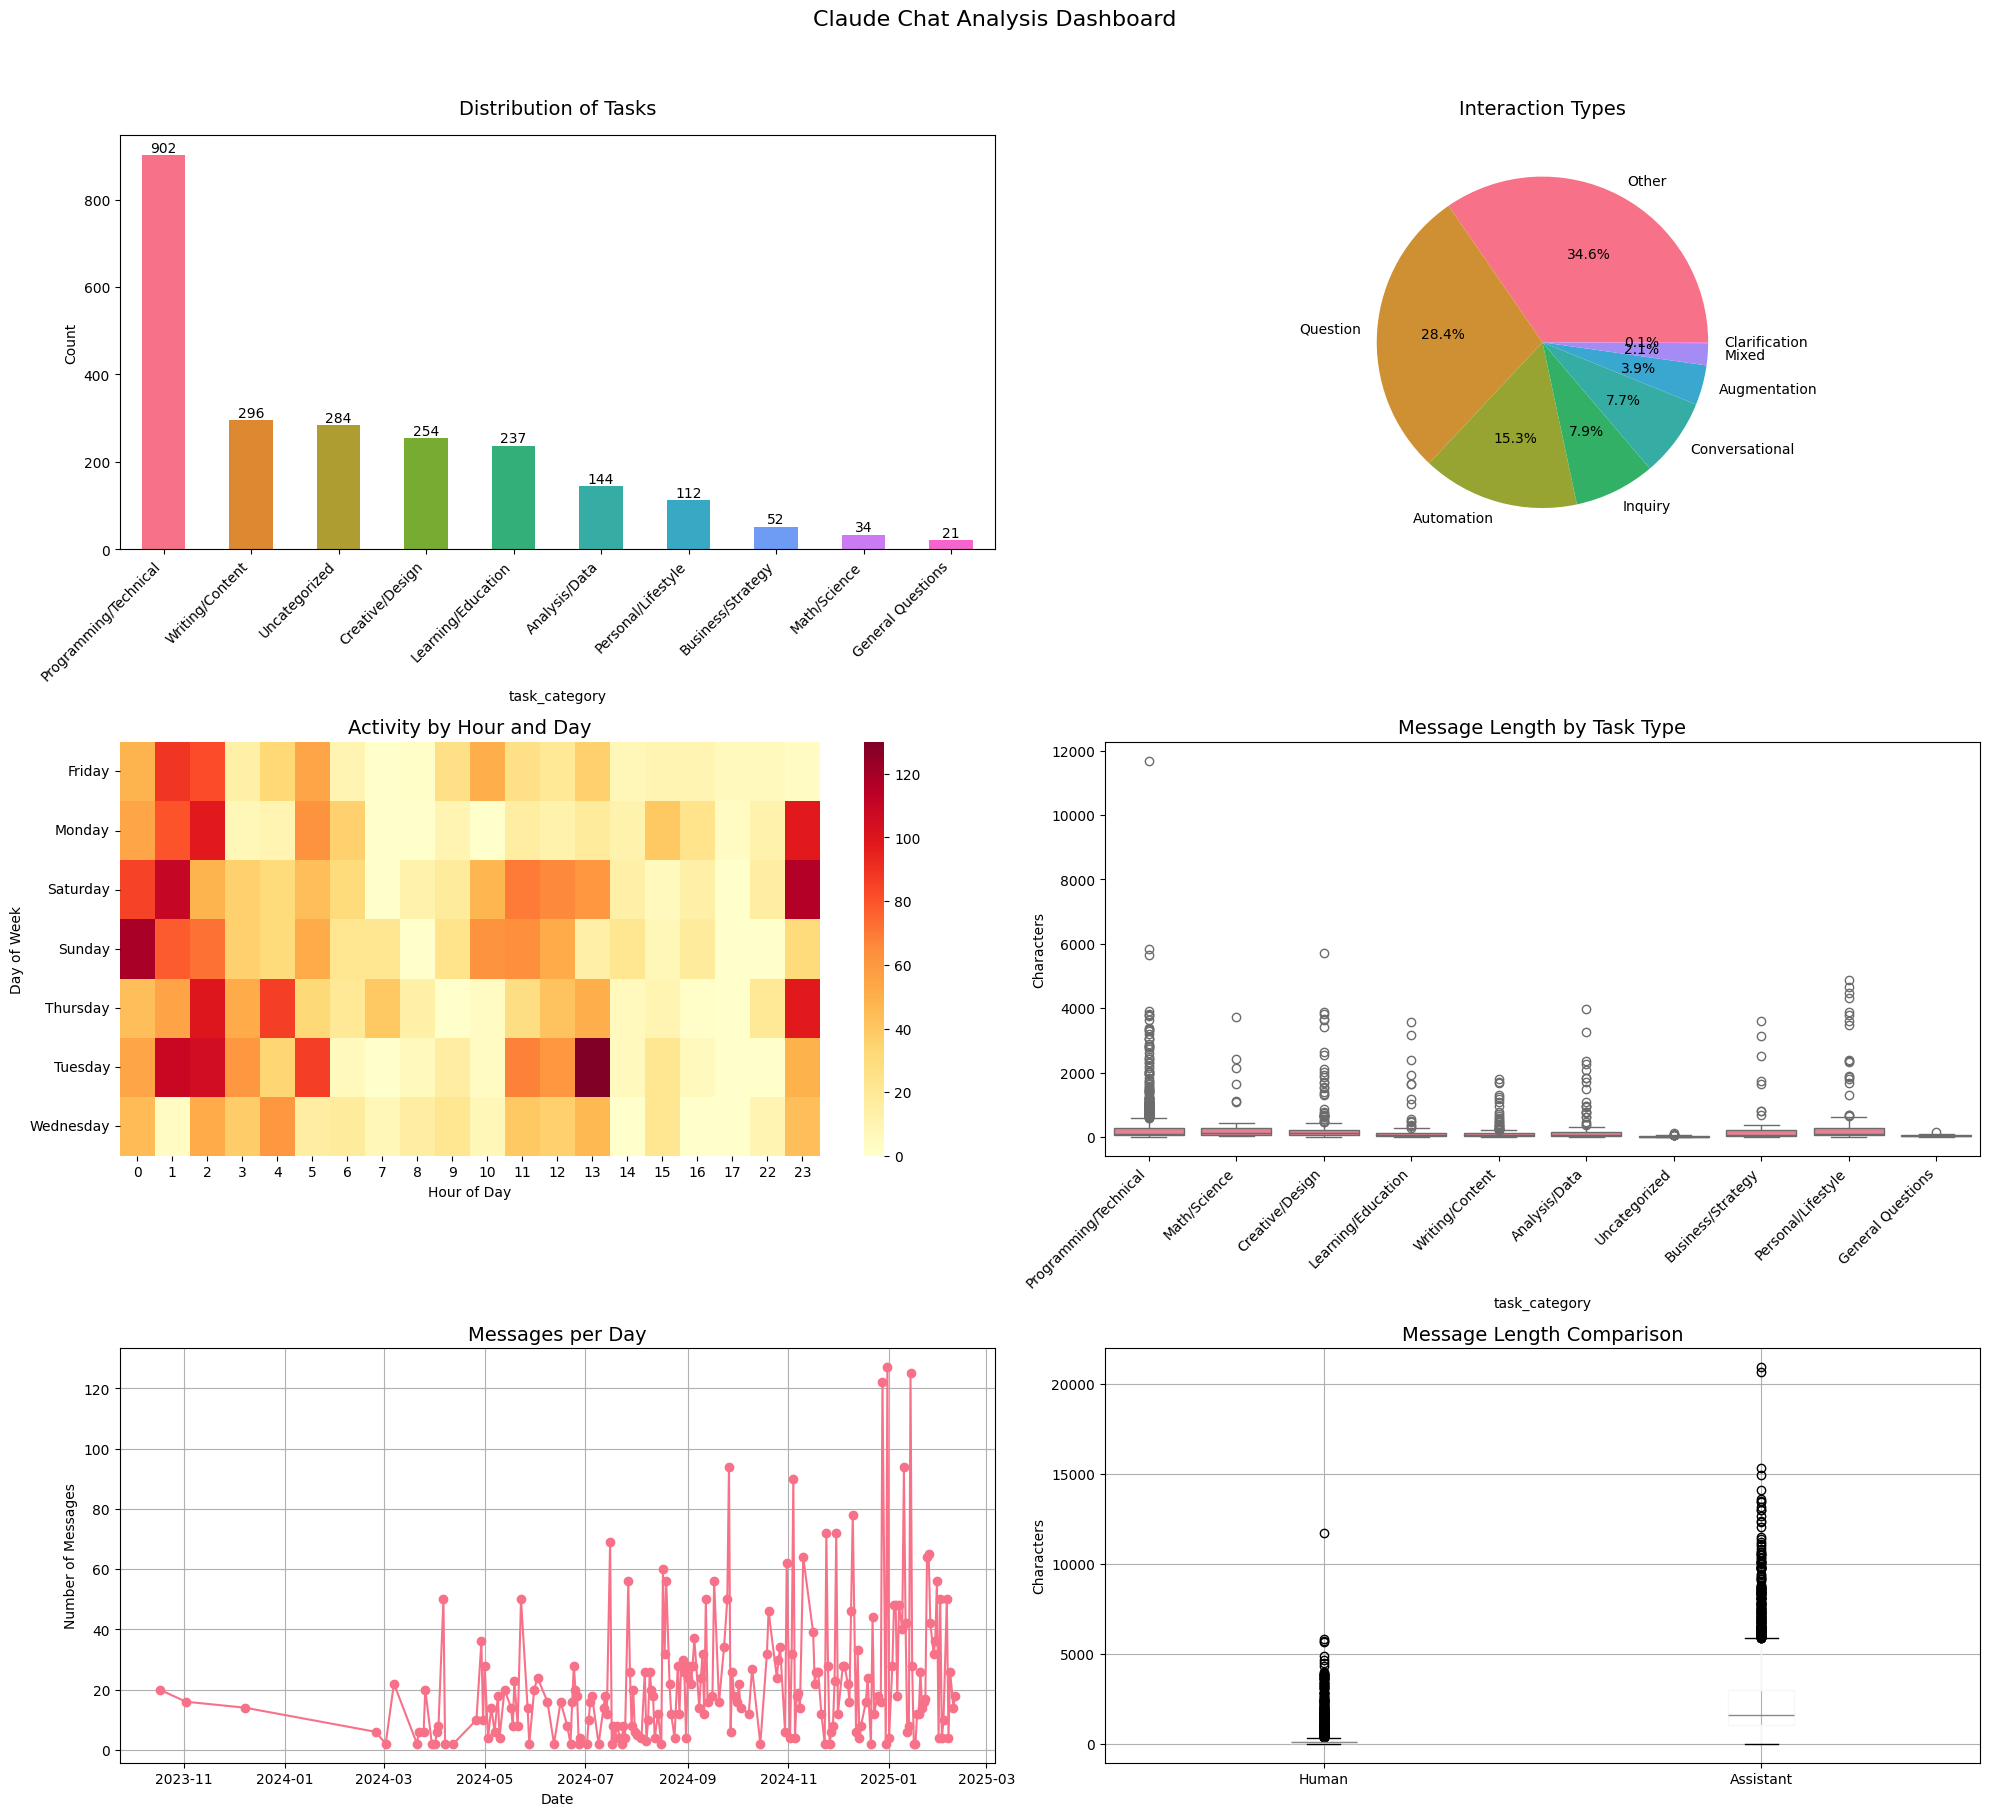

In [ ]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

plt.style.use('default')  # Use default style instead of seaborn
sns.set_palette("husl")   # Set seaborn color palette

def load_user_data(users_file):
    """Load and process users.json"""
    with open(users_file, 'r') as f:
        users = json.load(f)
    return pd.DataFrame(users)

def load_and_process_chats(conversations_file, users_df):
    """Load and process conversations.json with user information"""
    with open(conversations_file, 'r') as f:
        conversations = json.load(f)

    all_messages = []
    for conv in conversations:
        user_id = conv['account']['uuid']
        user_info = users_df[users_df['uuid'] == user_id].iloc[0] if len(users_df[users_df['uuid'] == user_id]) > 0 else None

        for msg in conv['chat_messages']:
            message = {
                'conversation_id': conv['uuid'],
                'conversation_name': conv['name'],
                'message_id': msg['uuid'],
                'sender': msg['sender'],
                'text': msg['text'],
                'timestamp': msg['created_at'],
                'has_files': len(msg.get('files', [])) > 0,
                'user_id': user_id,
                'user_name': user_info['full_name'] if user_info is not None else None,
                'user_email': user_info['email_address'] if user_info is not None else None
            }
            all_messages.append(message)

    return pd.DataFrame(all_messages)

def classify_task(text):
    """
    Classifies text into task categories with expanded patterns and categories.
    Returns the most likely category based on keyword matching.
    """
    patterns = {
        'Programming/Technical': r'code|program|function|bug|error|python|javascript|java|css|html|sql|api|debug|compile|runtime|server|database|git|docker|framework|library|package|npm|pip|dependency|algorithm|data\s?structure|variable|class|object|method|interface|exception|try|catch|async|promise|callback|rest|json|xml|http|request|response|file|path|directory|sdk|ide|editor|compiler|interpreter|syntax|loop|array|list|dict|hash|map|set|stack|queue|tree|graph|sort|search|optimize|performance|memory|cpu|thread|process|port|host|url|endpoint|regex|parser|lexer|token|command|terminal|shell|bash|powershell|linux|windows|mac|os|system|network|protocol|tcp|ip|dns|ssl|tls|security|auth|token|jwt|oauth|encrypt|decrypt|hash|cyber|firewall|proxy',

        'Writing/Content': r'write|draft|summarize|article|content|explain|rephrase|essay|blog|post|story|script|narrative|review|edit|proofread|grammar|spelling|tone|style|voice|paragraph|sentence|outline|structure|format|composition|document|letter|email|report|presentation|thesis|dissertation|paper|journal|publication|book|chapter|section|abstract|introduction|conclusion|summary|paraphrase|translate|translation|language|word|phrase|expression|idiom|metaphor|analogy|comparison|contrast|argument|thesis|evidence|citation|reference|quote|dialogue|monologue|description|narration|exposition|persuasion|rhetoric|clarity|conciseness|flow|coherence|cohesion|transition|revise|improve|enhance|polish|refine',

        'Analysis/Data': r'analyze|calculate|data|statistics|plot|graph|research|study|trend|pattern|correlation|regression|average|mean|median|mode|standard\s?deviation|variance|distribution|sample|population|hypothesis|test|significance|p-value|confidence|interval|prediction|forecast|model|metric|kpi|dashboard|visualization|chart|insight|inference|conclusion|excel|spreadsheet|csv|database|query|table|row|column|cell|pivot|vlookup|index|match|sum|count|average|filter|sort|group|aggregate|join|merge|clean|validate|normalize|transform|convert|extract|load|etl|bi|business\s?intelligence|reporting|analytics|measure|dimension|fact|cube|olap|warehouse|lake|mining|cluster|segment|classify|categorize|rank|score|benchmark|baseline|target|actual|variance|performance|accuracy|precision|recall|f1|roc|auc|confusion\s?matrix',

        'Learning/Education': r'learn|teach|understand|concept|explain|how|what|why|education|course|lesson|tutorial|guide|instruction|example|practice|exercise|homework|assignment|quiz|test|exam|grade|score|curriculum|syllabus|topic|subject|discipline|field|theory|principle|fundamental|basic|advanced|beginner|intermediate|expert|master|skill|knowledge|wisdom|comprehension|understanding|memory|recall|recognition|application|analysis|synthesis|evaluation|bloom|taxonomy|pedagogy|andragogy|learning\s?style|visual|auditory|kinesthetic|read|write|listen|speak|watch|observe|experiment|experience|reflect|think|process|integrate|connect|relate|associate|compare|contrast|differentiate|similar|different|same|opposite|before|after|cause|effect|problem|solution|question|answer|explanation|clarification|confusion|doubt|certainty|uncertainty|maybe|perhaps|probably|definitely',

        'Business/Strategy': r'business|strategy|market|plan|company|startup|product|service|customer|client|user|competitor|industry|sector|segment|target|goal|objective|mission|vision|value|proposition|revenue|cost|profit|loss|budget|forecast|projection|growth|scale|expansion|operation|process|workflow|team|organization|management|leadership|executive|ceo|cfo|cto|coo|board|director|manager|supervisor|employee|staff|personnel|hr|human\s?resources|recruit|hire|train|develop|retain|promote|compensate|benefit|salary|wage|bonus|stock|option|equity|share|stakeholder|shareholder|investor|investment|fund|capital|asset|liability|equity|balance|sheet|income|statement|cash|flow|accounting|finance|tax|legal|compliance|regulation|policy|procedure|standard|quality|control|assurance|audit|risk|opportunity|threat|strength|weakness|swot|pest|porter|canvas|lean|agile|scrum|kanban|waterfall|methodology|framework|best\s?practice|benchmark|metric|measure|performance|efficiency|effectiveness|productivity|output|outcome|impact|roi|return|investment|cost|benefit|analysis|feasibility|viability|sustainability',

        'Creative/Design': r'design|create|logo|image|graphic|art|creative|style|color|layout|template|theme|brand|identity|visual|aesthetic|interface|ui|ux|user\s?experience|wireframe|prototype|mockup|sketch|illustration|animation|video|audio|music|sound|effect|photo|picture|image|gallery|portfolio|collection|exhibition|showcase|display|presentation|slide|deck|powerpoint|keynote|prezi|font|typography|typeface|icon|symbol|sign|badge|banner|header|footer|navigation|menu|button|link|hover|click|tap|swipe|responsive|mobile|desktop|tablet|device|screen|resolution|pixel|vector|raster|bitmap|jpg|png|gif|svg|pdf|psd|ai|sketch|figma|adobe|creative\s?cloud|photoshop|illustrator|indesign|aftereffects|premiere|lightroom|dimension|xd|animate|media\s?encoder|acrobat|bridge|stock|colors|palette|scheme|contrast|brightness|saturation|hue|shade|tint|tone|warm|cool|neutral|primary|secondary|tertiary|complementary|analogous|monochromatic|gradient|pattern|texture|background|foreground|overlay|layer|mask|blend|filter|effect|transform|rotate|scale|skew|perspective|grid|alignment|spacing|padding|margin|border|shadow|highlight|depth|dimension|composition|balance|harmony|unity|variety|emphasis|movement|rhythm|proportion|scale|dominance|hierarchy|white\s?space|negative\s?space',

        'Personal/Lifestyle': r'advice|help|suggestion|recommendation|opinion|personal|life|work|career|job|interview|resume|cv|skill|experience|habit|routine|schedule|plan|goal|motivation|productivity|health|wellness|fitness|diet|nutrition|exercise|meditation|mindfulness|relationship|family|friend|love|romance|dating|marriage|partner|spouse|child|parent|sibling|relative|home|house|apartment|room|furniture|decoration|organization|cleaning|cooking|recipe|meal|food|drink|sleep|rest|relaxation|stress|anxiety|depression|mental|emotional|physical|spiritual|religious|belief|faith|philosophy|values|ethics|morals|principles|purpose|meaning|happiness|satisfaction|fulfillment|success|achievement|improvement|development|growth|change|transition|decision|choice|option|alternative|possibility|opportunity|challenge|obstacle|problem|solution|support|guidance|direction|path|journey|destination|future|past|present|time|management|balance|priority|importance|urgency|emergency|crisis|conflict|resolution|negotiation|communication|conversation|discussion|dialogue|message|feedback|response|reaction|emotion|feeling|thought|idea|inspiration|creativity|innovation|imagination|dream|goal|aspiration|ambition|motivation|drive|energy|passion|interest|hobby|activity|entertainment|fun|pleasure|enjoyment|satisfaction|comfort|convenience|luxury|necessity|need|want|desire|wish|hope|fear|worry|concern|care|attention|focus|concentration|memory|learning|knowledge|wisdom|experience|expertise|skill|talent|ability|capability|potential|strength|weakness|improvement|development|growth',

        'Math/Science': r'math|mathematics|equation|formula|calculation|proof|theorem|physics|chemistry|biology|science|scientific|experiment|observation|measurement|unit|conversion|geometry|algebra|calculus|trigonometry|probability|element|compound|reaction|force|energy|mass|volume|temperature|pressure|density|speed|velocity|acceleration|momentum|torque|gravity|friction|electricity|magnetism|wave|particle|atom|molecule|cell|tissue|organ|system|organism|species|population|community|ecosystem|environment|climate|weather|earth|space|planet|star|galaxy|universe|cosmos|quantum|relativity|mechanics|dynamics|statics|kinematics|thermodynamics|fluid|solid|gas|plasma|heat|light|sound|radiation|nuclear|chemical|biological|organic|inorganic|physical|theoretical|experimental|applied|pure|research|development|innovation|discovery|hypothesis|theory|law|principle|concept|model|simulation|analysis|synthesis|design|engineering|technology|computation|algorithm|program|code|data|information|knowledge|understanding|reasoning|logic|proof|evidence|observation|measurement|experiment|control|variable|constant|parameter|function|relation|correlation|causation|effect|result|outcome|conclusion|implication|application|problem|solution|method|technique|procedure|process|system|structure|organization|classification|categorization|taxonomy|hierarchy|network|graph|tree|matrix|vector|scalar|tensor|dimension|space|time|coordinate|axis|angle|distance|direction|orientation|position|motion|transformation|symmetry|pattern|sequence|series|progression|regression|distribution|probability|statistics|random|deterministic|chaos|complexity|emergence|evolution|adaptation|selection|mutation|variation|diversity|unity|duality|plurality|infinity',

        'General Questions': r'can you|could you|would you|how do|what is|why is|where is|when is|who is|which is|please help|need help|please tell|please explain|please describe|please advise|please suggest|please recommend|please guide|please assist|please provide|please share|please show|please demonstrate|please illustrate|please clarify|please elaborate|please specify|please verify|please confirm|please check|please review|please analyze|please evaluate|please assess|please examine|please investigate|please explore|please research|please find|please identify|please determine|please calculate|please compute|please estimate|please predict|please forecast|please project|please plan|please design|please develop|please create|please generate|please produce|please make|please build|please construct|please implement|please execute|please perform|please complete|please finish|please solve|please resolve|please fix|please repair|please improve|please enhance|please optimize|please maximize|please minimize|please increase|please decrease|please modify|please change|please update|please upgrade|please revise|please edit|please correct|please adjust|please adapt|please transform|please convert|please translate'
    }

    text = str(text).lower()
    category_scores = {category: 0 for category in patterns.keys()}

    # First pass: count exact matches for each category
    for category, pattern in patterns.items():
        matches = re.findall(pattern, text)
        category_scores[category] = len(matches)

    # If we found any matches, return the category with the most matches
    if any(category_scores.values()):
        return max(category_scores.items(), key=lambda x: x[1])[0]

    # Second pass: try partial word matches
    for category, pattern in patterns.items():
        keywords = pattern.split('|')
        for keyword in keywords:
            # Remove regex special characters and check if it's part of any word
            clean_keyword = re.sub(r'[\\()[\].*+?{}|]', '', keyword)
            if len(clean_keyword) > 3 and clean_keyword in text:  # Only match keywords longer than 3 chars
                category_scores[category] += 1  # Increment the count for this category

    # Return the category with the most partial matches, if any are found
    if any(category_scores.values()):
        return max(category_scores.items(), key=lambda x: x[1])[0]

    return "Uncategorized"

def analyze_interaction_type(text):
    """
    Analyzes the interaction type based on keywords in the text.
    Expanded categories include:
      - Automation: Imperative commands (e.g., write, generate, create, make, do, solve, build, develop)
      - Augmentation: Requests to enhance or improve (e.g., help, suggest, improve, review, teach, guide, understand, enhance, optimize, explain)
      - Clarification: Requests for more details (e.g., clarify, elaborate, detail, "explain more", "more info")
      - Inquiry/Question: If text includes question words or a question mark (e.g., what, how, why, when, where, which, or any text ending with '?')
      - Conversational: Greetings and casual conversation (e.g., hi, hello, hey, thanks, thank you)
      - Mixed: When both automation and augmentation cues are present
      - Other: When none of the above patterns match
    """
    import re

    text = str(text).lower()

    # Define regex patterns for each category
    automation_pattern = r'\b(write|generate|create|make|do|solve|build|develop)\b'
    augmentation_pattern = r'\b(help|suggest|improve|review|teach|guide|understand|enhance|optimize|explain)\b'
    inquiry_pattern = r'\b(what|how|why|when|where|which)\b'
    clarification_pattern = r'\b(clarify|elaborate|detail|explain more|more info)\b'
    conversational_pattern = r'\b(hi|hello|hey|good morning|good evening|thanks|thank you)\b'

    # Check for a question mark first
    if "?" in text:
        return 'Question'

    # Evaluate presence of patterns
    is_automation = bool(re.search(automation_pattern, text))
    is_augmentation = bool(re.search(augmentation_pattern, text))
    is_clarification = bool(re.search(clarification_pattern, text))
    is_inquiry = bool(re.search(inquiry_pattern, text))
    is_conversational = bool(re.search(conversational_pattern, text))

    # Determine category based on detected keywords:
    if is_automation and is_augmentation:
        return 'Mixed'
    elif is_automation:
        return 'Automation'
    elif is_augmentation:
        return 'Augmentation'
    elif is_clarification:
        return 'Clarification'
    elif is_inquiry:
        return 'Inquiry'
    elif is_conversational:
        return 'Conversational'
    else:
        return 'Other'

def analyze_chats(df):
    """Enhanced analysis with better visualizations"""
    # Create figure with better spacing
    plt.figure(figsize=(20, 25))

    # 1. Task Distribution
    plt.subplot(4, 2, 1)
    df.loc[df['sender'] == 'human', 'task_category'] = df[df['sender'] == 'human']['text'].apply(classify_task)
    task_dist = df['task_category'].value_counts()
    ax = task_dist.plot(kind='bar', color=sns.color_palette("husl", len(task_dist)))
    plt.title('Distribution of Tasks', fontsize=14, pad=15)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')

    # Add value labels
    for i, v in enumerate(task_dist):
        plt.text(i, v, str(v), ha='center', va='bottom')

    # 2. Interaction Types
    plt.subplot(4, 2, 2)
    df.loc[df['sender'] == 'human', 'interaction_type'] = df[df['sender'] == 'human']['text'].apply(analyze_interaction_type)
    interaction_dist = df['interaction_type'].value_counts()
    plt.pie(interaction_dist, labels=interaction_dist.index, autopct='%1.1f%%',
            colors=sns.color_palette("husl", len(interaction_dist)))
    plt.title('Interaction Types', fontsize=14, pad=15)

    # 3. Activity Heatmap
    plt.subplot(4, 2, 3)
    df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
    df['weekday'] = pd.to_datetime(df['timestamp']).dt.day_name()
    activity_pivot = pd.crosstab(df['weekday'], df['hour'])
    sns.heatmap(activity_pivot, cmap='YlOrRd')
    plt.title('Activity by Hour and Day', fontsize=14)
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')

    # 4. Message Length Distribution
    plt.subplot(4, 2, 4)
    df['message_length'] = df['text'].str.len()
    sns.boxplot(data=df, x='task_category', y='message_length')
    plt.title('Message Length by Task Type', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Characters')

    # 5. Daily Activity
    plt.subplot(4, 2, 5)
    daily_activity = df.groupby(pd.to_datetime(df['timestamp']).dt.date).size()
    daily_activity.plot(kind='line', marker='o')
    plt.title('Messages per Day', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Number of Messages')
    plt.grid(True)

    # 6. Response Time Analysis / Message Length Comparison
    plt.subplot(4, 2, 6)
    human_msgs = df[df['sender'] == 'human']
    assistant_msgs = df[df['sender'] == 'assistant']
    msg_lengths = pd.concat([
        human_msgs['text'].str.len().rename('Human'),
        assistant_msgs['text'].str.len().rename('Assistant')
    ], axis=1)
    msg_lengths.boxplot()
    plt.title('Message Length Comparison', fontsize=14)
    plt.ylabel('Characters')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle('Claude Chat Analysis Dashboard', fontsize=16, y=0.98)

    # Calculate statistics
    stats = {
        'total_conversations': df['conversation_id'].nunique(),
        'total_messages': len(df),
        'avg_messages_per_conv': len(df) / df['conversation_id'].nunique(),
        'task_distribution': task_dist,
        'interaction_distribution': interaction_dist,
        'daily_activity': daily_activity
    }

    return stats

def print_statistics(results):
    """Print statistics in a formatted way"""
    print("\n=== Chat Analysis Statistics ===\n")

    print(f"Total Conversations: {results['total_conversations']}")
    print(f"Total Messages: {results['total_messages']}")
    print(f"Average Messages per Conversation: {results['avg_messages_per_conv']:.1f}")

    print("\nTask Distribution:")
    print("-----------------")
    for task, count in results['task_distribution'].items():
        print(f"{task:<25}: {count:>5} ({count/sum(results['task_distribution'])*100:.1f}%)")

    print("\nInteraction Types:")
    print("-----------------")
    for type_, count in results['interaction_distribution'].items():
        print(f"{type_:<15}: {count:>5} ({count/sum(results['interaction_distribution'])*100:.1f}%)")

# Usage example:
if __name__ == "__main__":
    users_df = load_user_data('users.json')
    df = load_and_process_chats('conversations.json', users_df)
    results = analyze_chats(df)
    print_statistics(results)
    plt.show()



=== Chat Analysis Statistics ===

Total Conversations: 438
Total Messages: 4684
Average Messages per Conversation: 10.7

Task Distribution:
-----------------
Uncategorized            :   882 (37.8%)
Programming/Technical    :   576 (24.7%)
Writing/Content          :   271 (11.6%)
Creative/Design          :   192 (8.2%)
Analysis/Data            :   160 (6.8%)
General Questions        :   103 (4.4%)
Business/Strategy        :    56 (2.4%)
Learning/Education       :    51 (2.2%)
Personal/Lifestyle       :    43 (1.8%)
Math/Science             :     2 (0.1%)

Interaction Types:
-----------------
Question                 :   975 (41.7%)
Other                    :   795 (34.0%)
Automation (Directive)   :   279 (11.9%)
Conversational           :   176 (7.5%)
Automation (Feedback Loop):    61 (2.6%)
Automation (Directive, Feedback Loop):    26 (1.1%)
Augmentation (Learning)  :    20 (0.9%)
Mixed                    :     3 (0.1%)
Augmentation (Task Iteration):     1 (0.0%)

Occupational Mappin

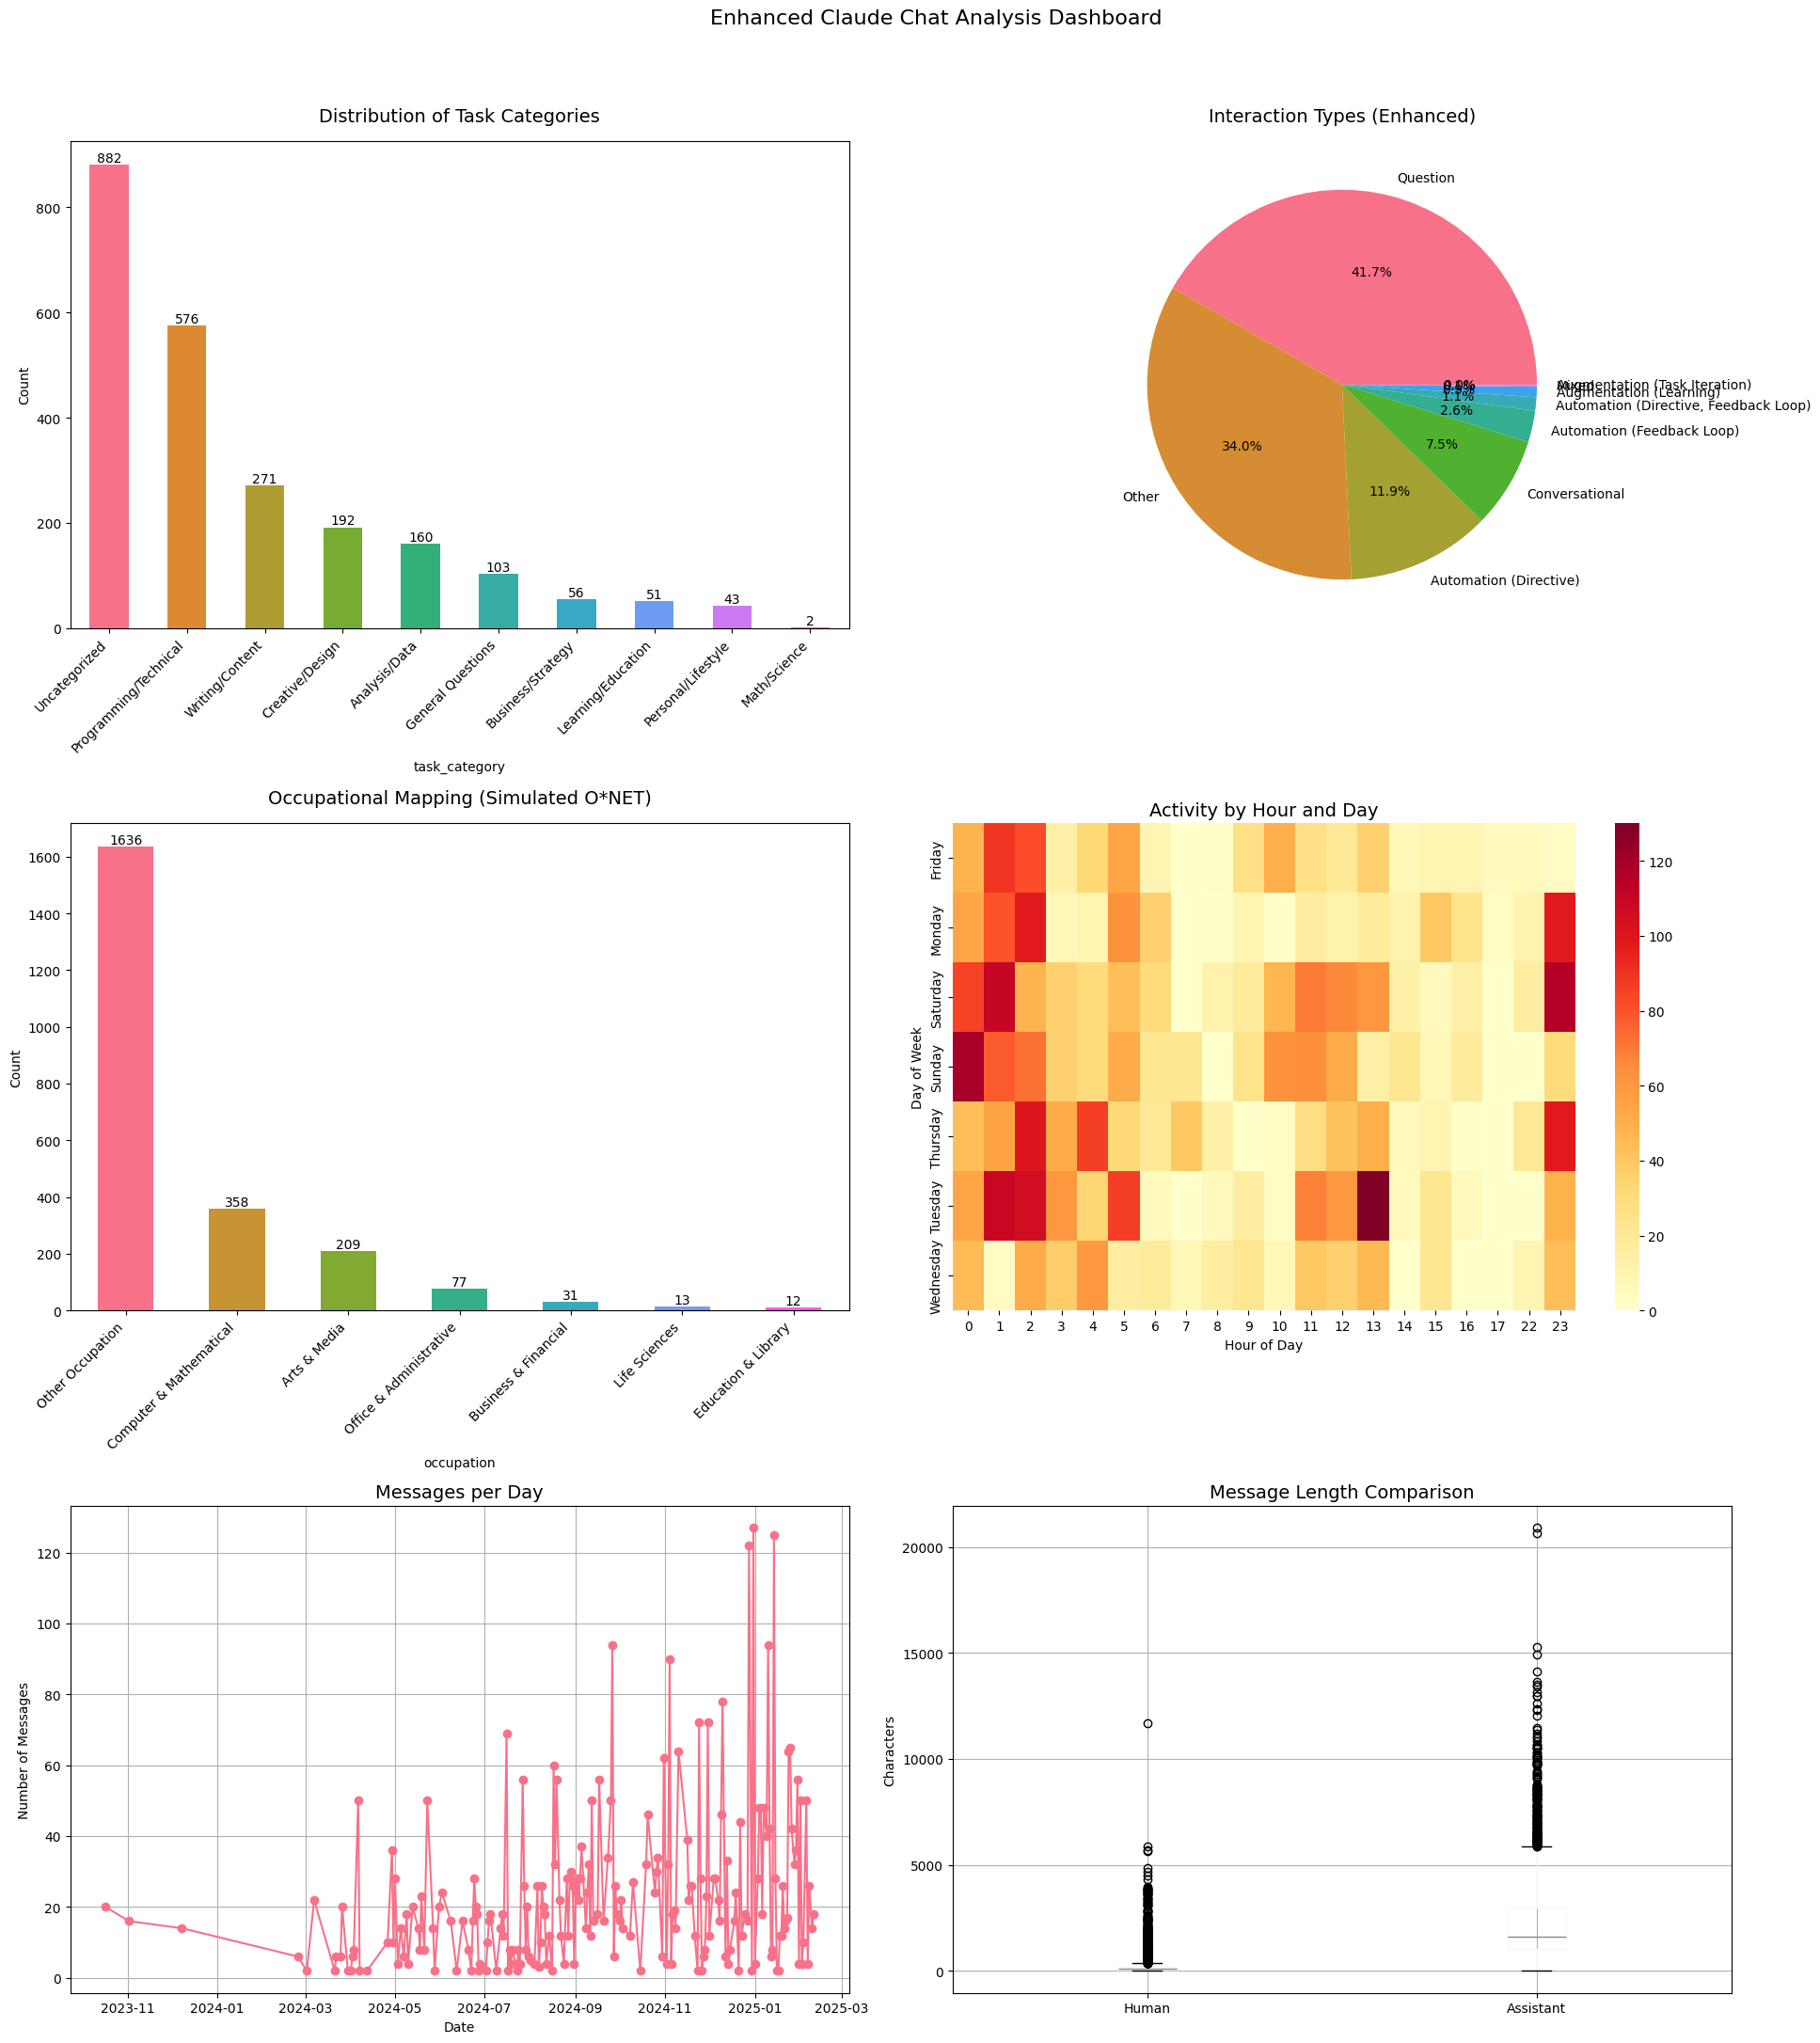

In [ ]:

import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

plt.style.use('default')
sns.set_palette("husl")

##########################
# Data Loading Functions #
##########################

def load_user_data(users_file):
    """Load and process users.json"""
    with open(users_file, 'r') as f:
        users = json.load(f)
    return pd.DataFrame(users)

def load_and_process_chats(conversations_file, users_df):
    """Load and process conversations.json with user information"""
    with open(conversations_file, 'r') as f:
        conversations = json.load(f)

    all_messages = []
    for conv in conversations:
        user_id = conv['account']['uuid']
        user_info = users_df[users_df['uuid'] == user_id].iloc[0] if len(users_df[users_df['uuid'] == user_id]) > 0 else None

        for msg in conv['chat_messages']:
            message = {
                'conversation_id': conv['uuid'],
                'conversation_name': conv['name'],
                'message_id': msg['uuid'],
                'sender': msg['sender'],
                'text': msg['text'],
                'timestamp': msg['created_at'],
                'has_files': len(msg.get('files', [])) > 0,
                'user_id': user_id,
                'user_name': user_info['full_name'] if user_info is not None else None,
                'user_email': user_info['email_address'] if user_info is not None else None
            }
            all_messages.append(message)

    return pd.DataFrame(all_messages)

##########################
# Classification Methods #
##########################

def classify_task(text):
    """
    Classifies text into broad task categories based on keyword matching.
    This remains similar to the original version.
    """
    patterns = {
        'Programming/Technical': r'code|program|function|bug|error|python|javascript|java|css|html|sql|api|debug|compile|runtime|server|database|git|docker',
        'Writing/Content': r'write|draft|summarize|article|content|rephrase|essay|blog|post|story|script|narrative|edit|proofread',
        'Analysis/Data': r'analyze|calculate|data|statistics|plot|graph|research|trend|pattern|regression|mean|median|mode',
        'Learning/Education': r'learn|teach|understand|explain|tutorial|guide|instruction',
        'Business/Strategy': r'business|strategy|market|plan|company|startup|product|service|customer|client',
        'Creative/Design': r'design|create|logo|graphic|art|image|illustration|animation',
        'Personal/Lifestyle': r'advice|help|suggest|recommendation|personal|career|job',
        'Math/Science': r'math|mathematics|equation|formula|physics|chemistry|biology',
        'General Questions': r'can you|could you|would you|how do|what is|why is'
    }

    text = str(text).lower()
    category_scores = {category: 0 for category in patterns.keys()}

    # Count exact matches
    for category, pattern in patterns.items():
        matches = re.findall(pattern, text)
        category_scores[category] = len(matches)

    if any(category_scores.values()):
        return max(category_scores.items(), key=lambda x: x[1])[0]

    # Partial matching (if no exact matches)
    for category, pattern in patterns.items():
        keywords = pattern.split('|')
        for keyword in keywords:
            clean_keyword = re.sub(r'[\\()[\].*+?{}|]', '', keyword)
            if len(clean_keyword) > 3 and clean_keyword in text:
                category_scores[category] += 1

    if any(category_scores.values()):
        return max(category_scores.items(), key=lambda x: x[1])[0]

    return "Uncategorized"

def map_to_occupation(text):
    """
    Simulated mapping to occupational categories using keywords.
    In a real application, you would map text to O*NET tasks/occupations.
    """
    occupation_mapping = {
        'Computer & Mathematical': r'code|program|debug|software|algorithm|database',
        'Arts & Media': r'write|blog|article|design|creative|graphic',
        'Education & Library': r'learn|teach|tutorial|education',
        'Office & Administrative': r'plan|schedule|manage|organize|report',
        'Life Sciences': r'biology|chemistry|physics|research|experiment',
        'Business & Financial': r'business|finance|market|investment|strategy'
    }

    text = str(text).lower()
    occ_scores = {occ: 0 for occ in occupation_mapping.keys()}

    for occ, pattern in occupation_mapping.items():
        matches = re.findall(pattern, text)
        occ_scores[occ] = len(matches)

    if any(occ_scores.values()):
        return max(occ_scores.items(), key=lambda x: x[1])[0]

    return "Other Occupation"

def analyze_interaction_type(text):
    """
    Enhanced interaction type classification.
    Expanded categories include:
      - Automation Subtypes:
         * Directive: complete command delegation (e.g., "write", "create")
         * Feedback Loop: requiring verification or iterative responses (e.g., "review", "check", "validate")
      - Augmentation Subtypes:
         * Task Iteration: collaborative refinement (e.g., "improve", "iterate", "brainstorm")
         * Learning/Validation: explanation and knowledge enhancement (e.g., "explain", "teach", "clarify")
      - Inquiry/Question: questions (detected via question mark or question words)
      - Conversational: greetings, thanks, casual conversation
      - Mixed: when multiple categories match
      - Other: default category
    """
    text = str(text).lower()

    # Patterns for subtypes
    directive_pattern = r'\b(write|generate|create|make|do|solve|build|develop)\b'
    feedback_pattern = r'\b(review|check|validate|verify)\b'
    iteration_pattern = r'\b(improve|iterate|refine|brainstorm)\b'
    learning_pattern = r'\b(explain|teach|clarify|detail)\b'
    inquiry_pattern = r'\b(what|how|why|when|where|which)\b'
    conversational_pattern = r'\b(hi|hello|hey|thanks|thank you)\b'

    # First, check if it's clearly a question
    if "?" in text or re.search(inquiry_pattern, text):
        base = 'Question'
    else:
        base = ''

    # Determine automation and augmentation cues
    is_directive = bool(re.search(directive_pattern, text))
    is_feedback = bool(re.search(feedback_pattern, text))
    is_iteration = bool(re.search(iteration_pattern, text))
    is_learning = bool(re.search(learning_pattern, text))
    is_conversational = bool(re.search(conversational_pattern, text))

    # Create lists to capture multiple signals
    automation_signals = []
    augmentation_signals = []

    if is_directive:
        automation_signals.append('Directive')
    if is_feedback:
        automation_signals.append('Feedback Loop')
    if is_iteration:
        augmentation_signals.append('Task Iteration')
    if is_learning:
        augmentation_signals.append('Learning')

    # If the text is question-like, return Question even if other signals are present.
    if base == 'Question':
        return 'Question'

    # If both automation and augmentation signals are present, mark as Mixed
    if automation_signals and augmentation_signals:
        return 'Mixed'
    elif automation_signals:
        return f"Automation ({', '.join(automation_signals)})"
    elif augmentation_signals:
        return f"Augmentation ({', '.join(augmentation_signals)})"
    elif is_conversational:
        return 'Conversational'
    else:
        return 'Other'

###################################
# Analysis and Visualization Code #
###################################

def analyze_chats(df):
    """Enhanced analysis with additional occupational mapping and refined interaction types"""
    plt.figure(figsize=(20, 30))

    # 1. Task Distribution Chart
    plt.subplot(4, 2, 1)
    df.loc[df['sender'] == 'human', 'task_category'] = df[df['sender'] == 'human']['text'].apply(classify_task)
    task_dist = df['task_category'].value_counts()
    task_dist.plot(kind='bar', color=sns.color_palette("husl", len(task_dist)))
    plt.title('Distribution of Task Categories', fontsize=14, pad=15)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    for i, v in enumerate(task_dist):
        plt.text(i, v, str(v), ha='center', va='bottom')

    # 2. Interaction Types Chart
    plt.subplot(4, 2, 2)
    df.loc[df['sender'] == 'human', 'interaction_type'] = df[df['sender'] == 'human']['text'].apply(analyze_interaction_type)
    interaction_dist = df['interaction_type'].value_counts()
    plt.pie(interaction_dist, labels=interaction_dist.index, autopct='%1.1f%%', colors=sns.color_palette("husl", len(interaction_dist)))
    plt.title('Interaction Types (Enhanced)', fontsize=14, pad=15)

    # 3. Occupational Mapping Chart
    plt.subplot(4, 2, 3)
    df.loc[df['sender'] == 'human', 'occupation'] = df[df['sender'] == 'human']['text'].apply(map_to_occupation)
    occ_dist = df['occupation'].value_counts()
    occ_dist.plot(kind='bar', color=sns.color_palette("husl", len(occ_dist)))
    plt.title('Occupational Mapping (Simulated O*NET)', fontsize=14, pad=15)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    for i, v in enumerate(occ_dist):
        plt.text(i, v, str(v), ha='center', va='bottom')

    # 4. Activity Heatmap
    plt.subplot(4, 2, 4)
    df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
    df['weekday'] = pd.to_datetime(df['timestamp']).dt.day_name()
    activity_pivot = pd.crosstab(df['weekday'], df['hour'])
    sns.heatmap(activity_pivot, cmap='YlOrRd')
    plt.title('Activity by Hour and Day', fontsize=14)
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')

    # 5. Daily Activity Line Chart
    plt.subplot(4, 2, 5)
    daily_activity = df.groupby(pd.to_datetime(df['timestamp']).dt.date).size()
    daily_activity.plot(kind='line', marker='o')
    plt.title('Messages per Day', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Number of Messages')
    plt.grid(True)

    # 6. Message Length Comparison
    plt.subplot(4, 2, 6)
    human_msgs = df[df['sender'] == 'human']
    assistant_msgs = df[df['sender'] == 'assistant']
    msg_lengths = pd.concat([
        human_msgs['text'].str.len().rename('Human'),
        assistant_msgs['text'].str.len().rename('Assistant')
    ], axis=1)
    msg_lengths.boxplot()
    plt.title('Message Length Comparison', fontsize=14)
    plt.ylabel('Characters')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle('Enhanced Claude Chat Analysis Dashboard', fontsize=16, y=0.98)

    # Calculate and return statistics for reporting
    stats = {
        'total_conversations': df['conversation_id'].nunique(),
        'total_messages': len(df),
        'avg_messages_per_conv': len(df) / df['conversation_id'].nunique(),
        'task_distribution': task_dist,
        'interaction_distribution': interaction_dist,
        'occupation_distribution': occ_dist,
        'daily_activity': daily_activity
    }

    return stats

def print_statistics(results):
    """Print statistics in a formatted way"""
    print("\n=== Chat Analysis Statistics ===\n")
    print(f"Total Conversations: {results['total_conversations']}")
    print(f"Total Messages: {results['total_messages']}")
    print(f"Average Messages per Conversation: {results['avg_messages_per_conv']:.1f}")

    print("\nTask Distribution:")
    print("-----------------")
    total_tasks = sum(results['task_distribution'])
    for task, count in results['task_distribution'].items():
        print(f"{task:<25}: {count:>5} ({count/total_tasks*100:.1f}%)")

    print("\nInteraction Types:")
    print("-----------------")
    total_inter = sum(results['interaction_distribution'])
    for itype, count in results['interaction_distribution'].items():
        print(f"{itype:<25}: {count:>5} ({count/total_inter*100:.1f}%)")

    print("\nOccupational Mapping:")
    print("---------------------")
    total_occ = sum(results['occupation_distribution'])
    for occ, count in results['occupation_distribution'].items():
        print(f"{occ:<25}: {count:>5} ({count/total_occ*100:.1f}%)")

###################################
# Main Usage Example              #
###################################

if __name__ == "__main__":
    users_df = load_user_data('users.json')
    df = load_and_process_chats('conversations.json', users_df)
    results = analyze_chats(df)
    print_statistics(results)
    plt.show()



=== Chat Analysis Statistics ===

Total Conversations: 438
Total Messages: 4684
Average Messages per Conversation: 10.7

Task Distribution:
-----------------
Learning/Understanding   :   902 (38.6%)
Programming/Technical    :   625 (26.8%)
Writing/Content          :   334 (14.3%)
Creative/Design          :   211 (9.0%)
Analysis/Data            :   155 (6.6%)
Business/Strategy        :    84 (3.6%)
Personal/Professional    :    15 (0.6%)
Math/Science             :    10 (0.4%)

Interaction Types:
-----------------
Automation     :  1452 (62.2%)
Augmentation   :   614 (26.3%)
Collaboration  :   270 (11.6%)


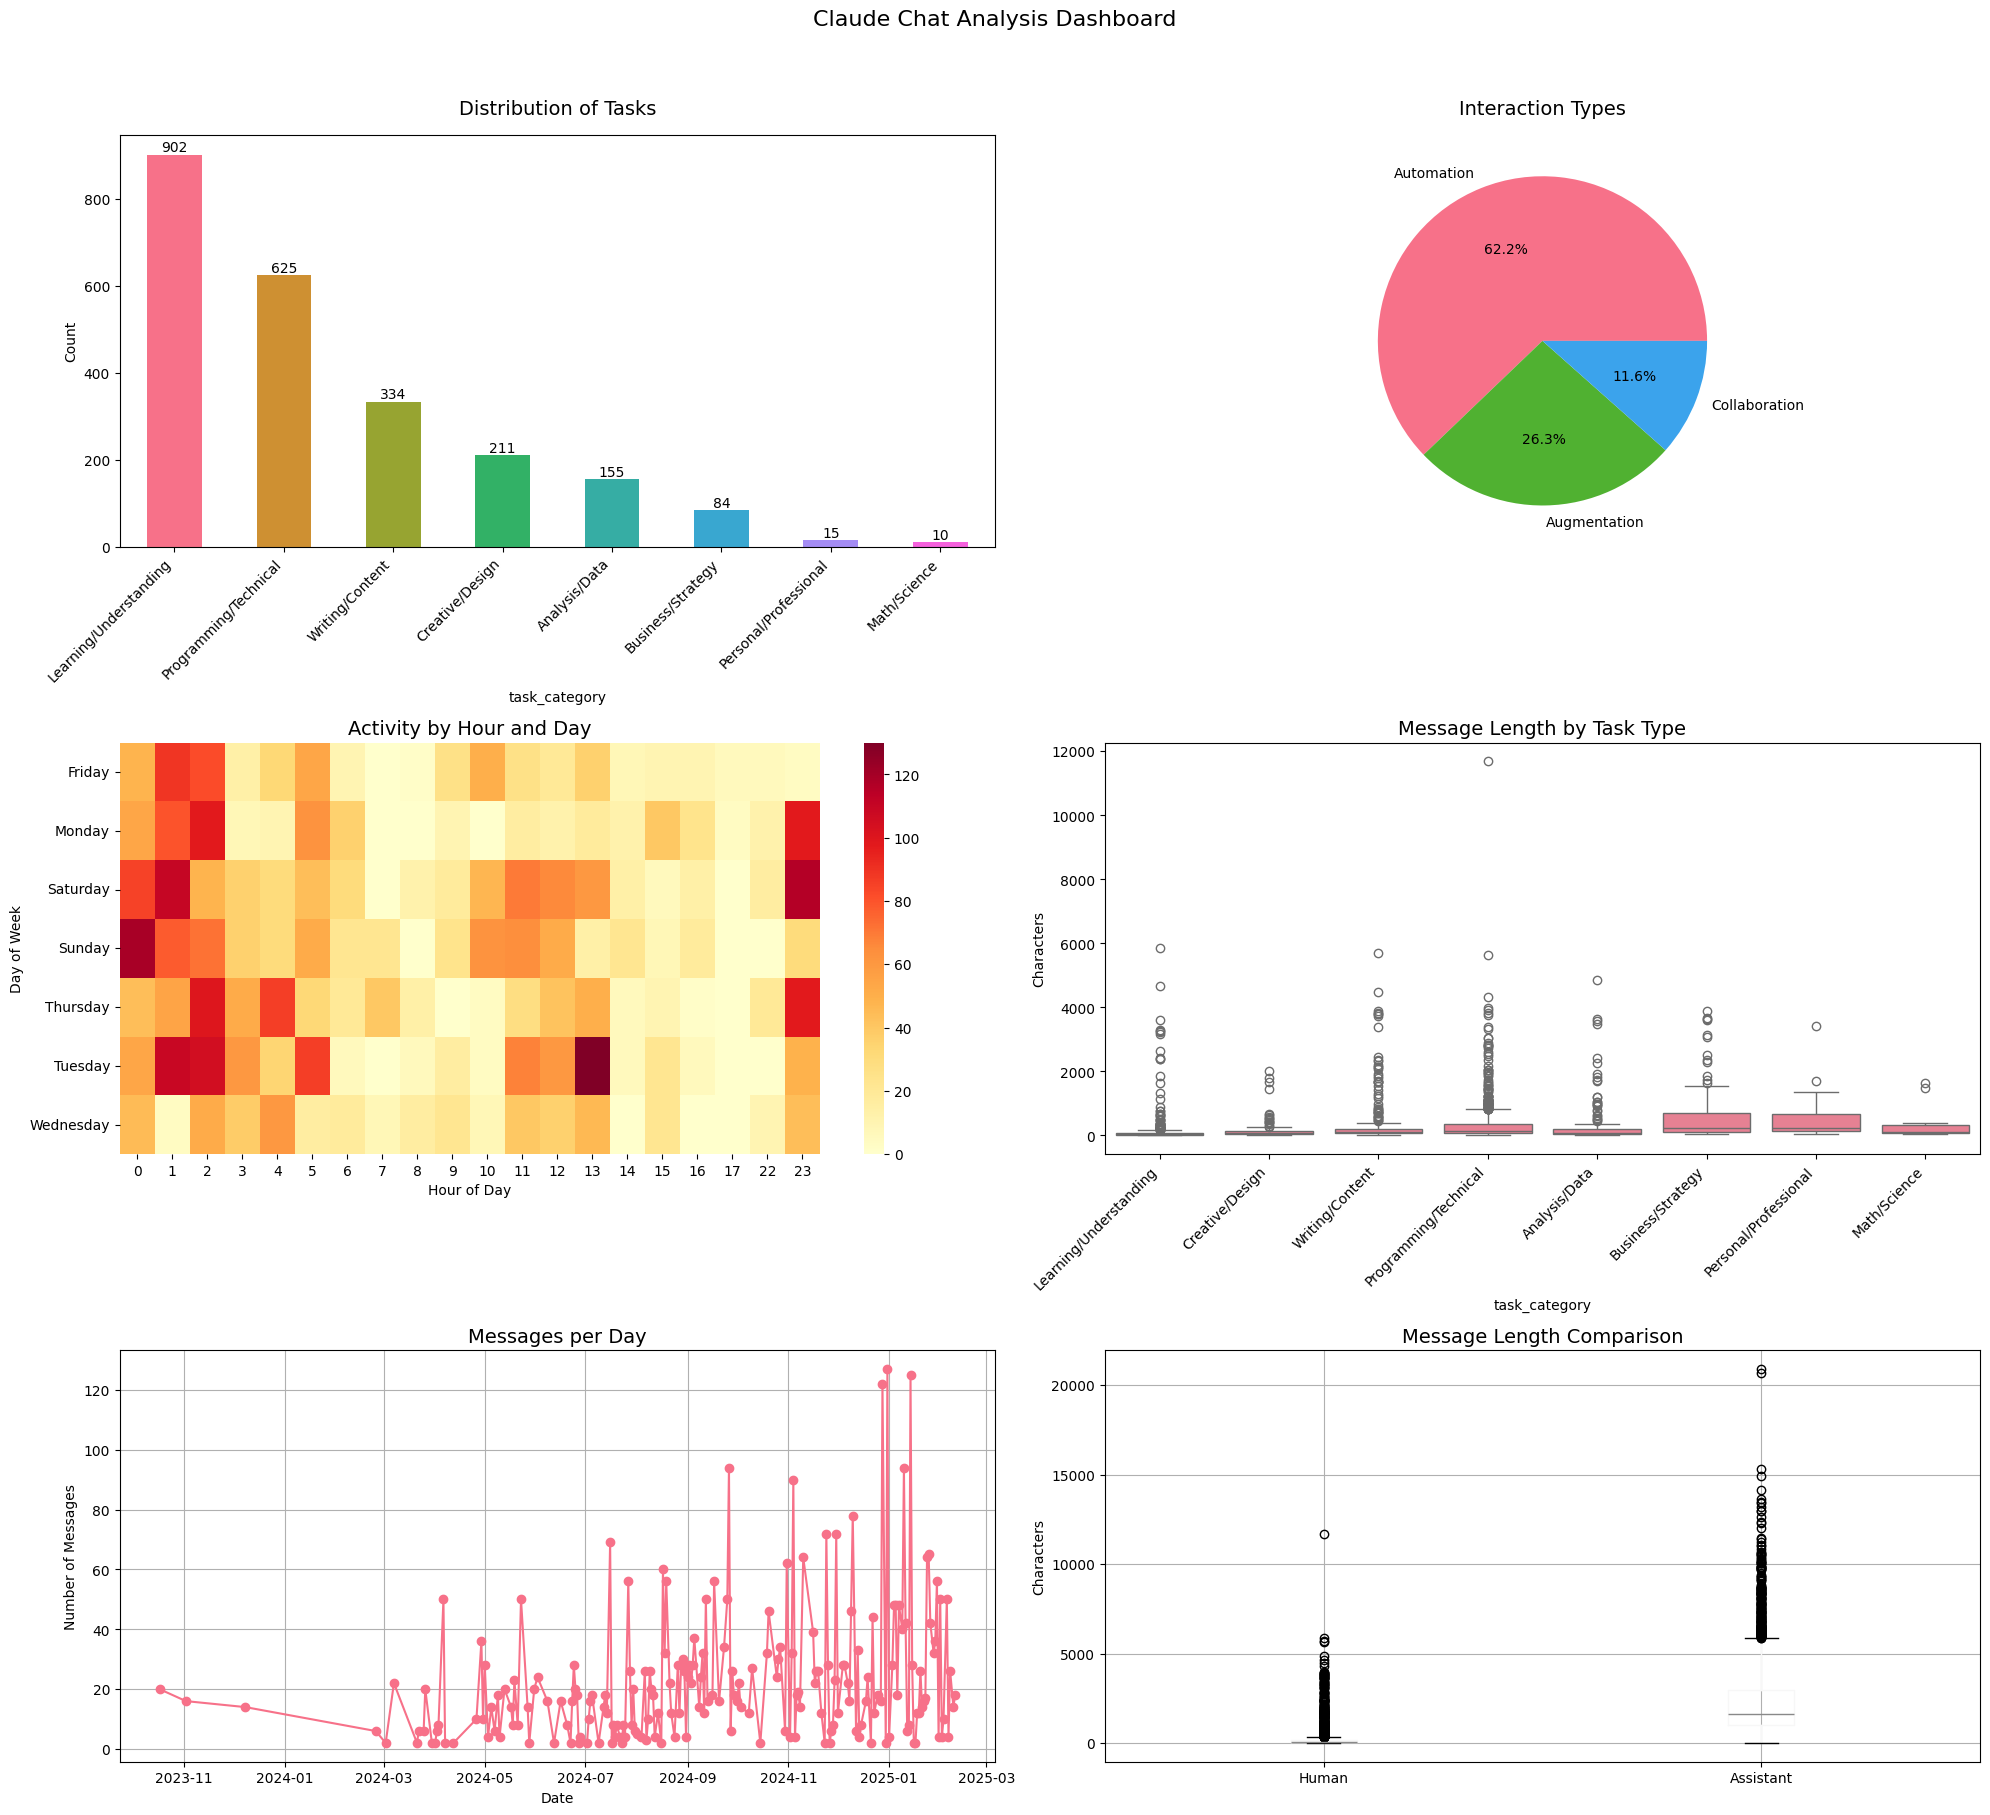


Validation samples saved to validation_samples.json

Task Categories with samples:
- Learning/Understanding: 2 samples
- Creative/Design: 2 samples
- Analysis/Data: 2 samples
- Writing/Content: 2 samples
- Business/Strategy: 2 samples
- Programming/Technical: 2 samples
- Personal/Professional: 2 samples
- Math/Science: 2 samples

Interaction Types with samples:
- Augmentation: 2 samples
- Collaboration: 2 samples
- Automation: 2 samples


In [ ]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

plt.style.use('default')  # Use default style instead of seaborn
sns.set_palette("husl")   # Set seaborn color palette

def load_user_data(users_file):
    """Load and process users.json"""
    with open(users_file, 'r') as f:
        users = json.load(f)
    return pd.DataFrame(users)

def load_and_process_chats(conversations_file, users_df):
    """Load and process conversations.json with user information"""
    with open(conversations_file, 'r') as f:
        conversations = json.load(f)

    all_messages = []
    for conv in conversations:
        user_id = conv['account']['uuid']
        user_info = users_df[users_df['uuid'] == user_id].iloc[0] if len(users_df[users_df['uuid'] == user_id]) > 0 else None

        for msg in conv['chat_messages']:
            message = {
                'conversation_id': conv['uuid'],
                'conversation_name': conv['name'],
                'message_id': msg['uuid'],
                'sender': msg['sender'],
                'text': msg['text'],
                'timestamp': msg['created_at'],
                'has_files': len(msg.get('files', [])) > 0,
                'user_id': user_id,
                'user_name': user_info['full_name'] if user_info is not None else None,
                'user_email': user_info['email_address'] if user_info is not None else None
            }
            all_messages.append(message)

    return pd.DataFrame(all_messages)

def classify_task(text):
    """
    Improved task classifier with better general query handling
    """
    text = str(text).lower()

    # Define more specific patterns for each category
    patterns = {
        'Programming/Technical': r'\b(code|program|script|bug|error|python|javascript|java|css|html|sql|api|debug|compile|git|docker|library|package|algorithm|variable|class|object|method|interface|loop|array|list|regex|server|database|file|path|directory|function|module|error|exception|syntax|backend|frontend|framework|deployment|hosting)\b',

        'Writing/Content': r'\b(write|draft|summarize|article|content|essay|blog|post|story|edit|proofread|grammar|spelling|tone|style|paragraph|sentence|document|letter|email|report|thesis|translate|rephrase|rewrite|content|copy|script|narrative|text|revision|draft)\b',

        'Analysis/Data': r'\b(analyze|examine|calculate|data|statistics|plot|graph|trend|pattern|correlation|average|mean|median|variance|sample|test|metric|dashboard|chart|excel|spreadsheet|csv|query|table|filter|sort|report|insights|visualization|analytics|forecast|predict)\b',

        'Learning/Understanding': r'\b(learn|teach|understand|explain|concept|course|lesson|tutorial|guide|example|practice|assignment|topic|theory|principle|fundamental|basic|advanced|knowledge|comprehension|clarify|elaborate|describe|define|meaning|difference|compare|contrast)\b',

        'Business/Strategy': r'\b(business|strategy|market|plan|company|startup|product|service|customer|client|industry|target|goal|objective|revenue|cost|profit|budget|team|management|project|timeline|requirement|stakeholder|investor|finance|sales|marketing|growth|scale|ROI|KPI)\b',

        'Creative/Design': r'\b(design|create|graphic|art|creative|style|color|layout|template|brand|visual|interface|ui|ux|prototype|mockup|sketch|illustration|animation|image|photo|logo|aesthetic|theme|palette|typography|responsive|mobile|desktop)\b',

        'Personal/Professional': r'\b(career|job|interview|resume|cv|skill|experience|professional|development|growth|advancement|promotion|salary|work-life|balance|time\s?management|productivity|leadership|communication|soft\s?skills|networking|mentorship|coaching)\b',

        'Math/Science': r'\b(math|equation|formula|calculation|proof|physics|chemistry|biology|science|experiment|measurement|geometry|algebra|calculus|probability|engineering|force|mass|volume|temperature|hypothesis|theory|research|methodology|observation|data\s?collection)\b'
    }

    # Check exact matches first
    category_scores = {category: 0 for category in patterns.keys()}
    for category, pattern in patterns.items():
        matches = len(re.findall(pattern, text))
        if matches > 0:
            category_scores[category] = matches

    # If we have any matches, return the highest scoring category
    if any(category_scores.values()):
        return max(category_scores.items(), key=lambda x: x[1])[0]

    # Check for learning/understanding indicators in questions
    if '?' in text and any(word in text for word in ['how', 'why', 'what', 'explain']):
        return 'Learning/Understanding'

    # Check for general analysis requests
    if any(word in text for word in ['analyze', 'examine', 'review', 'check', 'look at']):
        return 'Analysis/Data'

    # Check for creative requests
    if any(word in text for word in ['create', 'make', 'design', 'generate']):
        return 'Creative/Design'

    return 'Learning/Understanding'  # Default to this instead of Conversation/General

def analyze_interaction_type(text):
    """
    Final rebalanced interaction type analyzer with stronger collaboration detection
    """
    text = str(text).lower()
    scores = {'Automation': 0, 'Augmentation': 0, 'Collaboration': 0}

    # Detect questions first - they strongly indicate Augmentation or Collaboration
    if '?' in text:
        if any(word in text for word in ['how', 'why', 'what', 'when', 'where', 'who']):
            scores['Augmentation'] += 3
        elif any(word in text for word in ['can', 'could', 'would', 'will']):
            if any(word in text for word in ['we', 'together', 'discuss']):
                scores['Collaboration'] += 3
            elif any(word in text for word in ['help', 'explain', 'guide', 'assist']):
                scores['Augmentation'] += 3
            else:
                scores['Automation'] += 1

    # Collaboration patterns (weighted very heavily)
    collab_indicators = [
        (r'\blet\'s\b', 4),
        (r'\btogether\b', 4),
        (r'\bwe\b.*\btry\b', 4),
        (r'\bwork with me\b', 4),
        (r'\b(your thoughts|your opinion|your feedback)\b', 4),
        (r'\bwhat (do|would) you think\b', 4),
        (r'\bhow (should|could|would) we\b', 4),
        (r'\bcan we\b', 3),
        (r'\bdo you think\b', 3),
        (r'\bwhat if\b', 3),
        (r'\bbrainstorm\b', 4),
        (r'\bdiscuss\b', 3),
        (r'\bsuggest\b', 3)
    ]

    for pattern, weight in collab_indicators:
        if re.search(pattern, text):
            scores['Collaboration'] += weight

    # Augmentation patterns (weighted moderately)
    augmentation_indicators = [
        (r'\bhelp me\b', 3),
        (r'\bguide me\b', 3),
        (r'\bteach me\b', 3),
        (r'\bexplain\b', 3),
        (r'\bclarify\b', 3),
        (r'\bunderstand\b', 3),
        (r'\breview\b', 2),
        (r'\bcheck\b', 2),
        (r'\badvise\b', 2),
        (r'\blearn\b', 3),
        (r'\bshow me how\b', 3),
        (r'\bi\'m trying to\b', 2)
    ]

    for pattern, weight in augmentation_indicators:
        if re.search(pattern, text):
            scores['Augmentation'] += weight

    # Automation patterns (weighted less heavily)
    automation_indicators = [
        (r'\b(write|create|generate|make)\b.*\b(a|an|the)\b', 2),
        (r'\bprovide\b.*\b(a|an|the)\b', 2),
        (r'\bgive me\b.*\b(a|an|the)\b', 2),
        (r'\bproduct\b', 1),
        (r'\bcalculate\b', 1),
        (r'\bcompute\b', 1)
    ]

    for pattern, weight in automation_indicators:
        if re.search(pattern, text):
            scores['Automation'] += weight

    # Context modifiers
    if any(phrase in text for phrase in ['i need help', 'can you help', 'please help']):
        scores['Augmentation'] += 2

    if any(phrase in text for phrase in ['what do you think about', 'how would you', 'do you believe']):
        scores['Collaboration'] += 3

    # Get highest score
    max_score = max(scores.values())
    if max_score == 0:
        # Better default case logic
        if '?' in text:
            return 'Augmentation'
        elif any(word in text for word in ['help', 'explain', 'understand']):
            return 'Augmentation'
        elif any(word in text for word in ['we', 'together', 'discuss']):
            return 'Collaboration'
        return 'Automation'

    # Improved tiebreaking logic
    max_categories = [cat for cat, score in scores.items() if score == max_score]
    if len(max_categories) == 1:
        return max_categories[0]

    # Prioritize Collaboration and Augmentation in ties
    if 'Collaboration' in max_categories and scores['Collaboration'] >= 3:
        return 'Collaboration'
    if 'Augmentation' in max_categories:
        return 'Augmentation'
    return 'Automation'

def analyze_chats(df):
    """Enhanced analysis with better visualizations"""
    # Create figure with better spacing
    plt.figure(figsize=(20, 25))

    # 1. Task Distribution
    plt.subplot(4, 2, 1)
    df['task_category'] = df[df['sender'] == 'human']['text'].apply(classify_task)
    task_dist = df['task_category'].value_counts()
    ax = task_dist.plot(kind='bar', color=sns.color_palette("husl", len(task_dist)))
    plt.title('Distribution of Tasks', fontsize=14, pad=15)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')

    # Add value labels
    for i, v in enumerate(task_dist):
        plt.text(i, v, str(v), ha='center', va='bottom')

    # 2. Interaction Types
    plt.subplot(4, 2, 2)
    df['interaction_type'] = df[df['sender'] == 'human']['text'].apply(analyze_interaction_type)
    interaction_dist = df['interaction_type'].value_counts()
    plt.pie(interaction_dist, labels=interaction_dist.index, autopct='%1.1f%%',
            colors=sns.color_palette("husl", len(interaction_dist)))
    plt.title('Interaction Types', fontsize=14, pad=15)

    # 3. Activity Heatmap
    plt.subplot(4, 2, 3)
    df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
    df['weekday'] = pd.to_datetime(df['timestamp']).dt.day_name()
    activity_pivot = pd.crosstab(df['weekday'], df['hour'])
    sns.heatmap(activity_pivot, cmap='YlOrRd')
    plt.title('Activity by Hour and Day', fontsize=14)
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')

    # 4. Message Length Distribution
    plt.subplot(4, 2, 4)
    df['message_length'] = df['text'].str.len()
    sns.boxplot(data=df, x='task_category', y='message_length')
    plt.title('Message Length by Task Type', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Characters')

    # 5. Daily Activity
    plt.subplot(4, 2, 5)
    daily_activity = df.groupby(pd.to_datetime(df['timestamp']).dt.date).size()
    daily_activity.plot(kind='line', marker='o')
    plt.title('Messages per Day', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Number of Messages')
    plt.grid(True)

    # 6. Response Time Analysis
    plt.subplot(4, 2, 6)
    human_msgs = df[df['sender'] == 'human']
    assistant_msgs = df[df['sender'] == 'assistant']
    msg_lengths = pd.concat([
        human_msgs['text'].str.len().rename('Human'),
        assistant_msgs['text'].str.len().rename('Assistant')
    ], axis=1)
    msg_lengths.boxplot()
    plt.title('Message Length Comparison', fontsize=14)
    plt.ylabel('Characters')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle('Claude Chat Analysis Dashboard', fontsize=16, y=0.98)

    # Calculate statistics
    stats = {
        'total_conversations': df['conversation_id'].nunique(),
        'total_messages': len(df),
        'avg_messages_per_conv': len(df) / df['conversation_id'].nunique(),
        'task_distribution': task_dist,
        'interaction_distribution': interaction_dist,
        'daily_activity': daily_activity
    }

    return stats

def print_statistics(results):
    """Print statistics in a formatted way"""
    print("\n=== Chat Analysis Statistics ===\n")

    print(f"Total Conversations: {results['total_conversations']}")
    print(f"Total Messages: {results['total_messages']}")
    print(f"Average Messages per Conversation: {results['avg_messages_per_conv']:.1f}")

    print("\nTask Distribution:")
    print("-----------------")
    for task, count in results['task_distribution'].items():
        print(f"{task:<25}: {count:>5} ({count/sum(results['task_distribution'])*100:.1f}%)")

    print("\nInteraction Types:")
    print("-----------------")
    for type_, count in results['interaction_distribution'].items():
        print(f"{type_:<15}: {count:>5} ({count/sum(results['interaction_distribution'])*100:.1f}%)")
def save_validation_samples(df, output_file='validation_samples.json'):
    """
    Save sample conversations for each task category and interaction type
    for validation purposes.

    Args:
        df: DataFrame with processed chat data
        output_file: JSON file to save the samples
    """
    import json
    from collections import defaultdict

    # Initialize containers for samples
    task_samples = defaultdict(list)
    interaction_samples = defaultdict(list)

    # Process each conversation
    for conv_id in df['conversation_id'].unique():
        conv_msgs = df[df['conversation_id'] == conv_id].copy()
        if len(conv_msgs) == 0:
            continue

        # Get first human message in conversation
        first_human_msg = conv_msgs[conv_msgs['sender'] == 'human'].iloc[0]

        # Get task category and interaction type
        task_cat = classify_task(first_human_msg['text'])
        interaction_type = analyze_interaction_type(first_human_msg['text'])

        # Create conversation sample
        sample = {
            'conversation_id': conv_id,
            'first_message': first_human_msg['text'],
            'messages': conv_msgs[['sender', 'text']].to_dict('records')[:3],  # First 3 messages
            'classified_as': task_cat if task_cat else 'Unknown'
        }

        # Store samples (keep only 2 per category)
        if len(task_samples[task_cat]) < 2:
            task_samples[task_cat].append(sample)

        sample['classified_as'] = interaction_type
        if len(interaction_samples[interaction_type]) < 2:
            interaction_samples[interaction_type].append(sample)

    # Combine all samples
    validation_data = {
        'task_categories': dict(task_samples),
        'interaction_types': dict(interaction_samples)
    }

    # Save to file
    with open(output_file, 'w') as f:
        json.dump(validation_data, f, indent=2)

    # Quick summary of collected samples
    print(f"\nValidation samples saved to {output_file}")
    print("\nTask Categories with samples:")
    for category, samples in task_samples.items():
        print(f"- {category}: {len(samples)} samples")
    print("\nInteraction Types with samples:")
    for itype, samples in interaction_samples.items():
        print(f"- {itype}: {len(samples)} samples")

# Usage example:
if __name__ == "__main__":
    users_df = load_user_data('users.json')
    df = load_and_process_chats('conversations.json', users_df)
    results = analyze_chats(df)
    print_statistics(results)
    plt.show()
    # Save validation samples
    save_validation_samples(df)
